In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import re
import pickle
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

#filepath = "/content/gdrive/MyDrive/datasets/plots_text.pickle"


#train_filepath = '/content/gdrive/MyDrive/gpt2/dataset/train_companies_eng_cover_letters.csv'
#val_filepath = '/content/gdrive/MyDrive/gpt2/dataset/val_companies_eng_cover_letters.csv'
data_filepath = '/content/gdrive/MyDrive/gpt2/dataset/clean_key_field_cover_letters.csv'
test_filepath = '/content/gdrive/MyDrive/gpt2/dataset/clean_test_key_field_cover_letters.csv'

dataset = pd.read_csv(data_filepath)
test = pd.read_csv(test_filepath)
train_df = dataset[:int(len(dataset)*0.9)]
val_df = dataset[int(len(dataset)*0.9):]


# read pickle file
#pickle_in = open(filepath,"rb")
#dataset = pickle.load(pickle_in)


applications = list(dataset['fields']+'\n'+ dataset['text'])# + (list(test['fields']+'\n'+ test['text']))

train_applications = list(train_df['fields']+'\n'+ train_df['text'])
val_applications = list(val_df['fields']+'\n'+ val_df['text'])


In [ ]:
len(applications)

1881

In [ ]:
def create_seq(text, seq_len = 5):
    
    sequences = []

    # if the number of tokens in 'text' is greater than 5
    if len(text.split()) > seq_len:
      for i in range(seq_len, len(text.split())):
        # select sequence of tokens
        seq = text.split()[i-seq_len:i+1]
        # add to the list
        sequences.append(" ".join(seq))

      return sequences

    # if the number of tokens in 'text' is less than or equal to 5
    else:
      
      return [text]

seqs = [create_seq(str(i)) for i in applications]
seqs_train = [create_seq(str(i)) for i in train_applications]
seqs_val = [create_seq(str(i)) for i in val_applications]


# merge list-of-lists into a single list
seqs = sum(seqs, [])
seqs_train = sum(seqs_train, [])
seqs_val = sum(seqs_val, [])
# count of sequences

print(seqs[:5])


# create inputs and targets (x and y)
x = []
y = []

for s in seqs:
  x.append(" ".join(s.split()[:-1]))
  y.append(" ".join(s.split()[1:]))

x_train = []
y_train = []

for s in seqs_train:
  x_train.append(" ".join(s.split()[:-1]))
  y_train.append(" ".join(s.split()[1:]))

x_val = []
y_val = []

for s in seqs_val:
  x_val.append(" ".join(s.split()[:-1]))
  y_val.append(" ".join(s.split()[1:]))




['Account Assistant Cover Letter When I', 'Assistant Cover Letter When I learned', 'Cover Letter When I learned of', 'Letter When I learned of ShopKeeper’s', 'When I learned of ShopKeeper’s need']


In [ ]:
applications = [application for application in applications if type(application) == str]
train_applications = [application for application in train_applications if type(application) == str]
val_applications = [application for application in val_applications if type(application) == str]

len(applications)

1881

In [ ]:
# create integer-to-token mapping
int2token = {}
cnt = 0

for w in set(" ".join(applications).split()):
  print(w)
  if type(w) == str:
    int2token[cnt] = str(w)
    cnt+= 1

# create token-to-integer mapping
token2int = {t: i for i, t in int2token.items()}

#print(token2int["the"], int2token[14271])


# set vocabulary size
vocab_size = len(int2token)
print(vocab_size)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
variables
consultancy-based
Greeting
Lexus—as
paging
Twitter;
Other
carpentry,
<em>Pronghorn
Sew
Day
actual
inquiries.
civilian
desserts.
establishing,
Mario
Davidson
textured
sellers
goals—as
proposals
Atlantic
Jigs,
providing
Container
Homemaking
agency
meters,
references,
Analysis.
2,000+
salesman
Total
offering:
period.
generates
clearing
sitcoms,
callers
behalf,
mitigation,
Texas
higher
efficiencies.
Boy
sells
aids,
pelvic,
owners’departure
43%,
30+
act
Spirit.
populations,
tasks—including
regulation
Smack
vital.
already-restrained
GAAP,
CodeSource.
yards
Wayne.
Broker
offerings,
generation;
aims
four-year
customized
Discussed
honed
Louisville
Yours
Dry
Academy’s
house
Oregon,
disbursement,
Recruiter.
months—in
effluent
Barista
Identification
consequence
Charlotte,
Instruction,
clarifying
Telecommunications/Network
Consulting.
ceramic
VIP
entered
BA
ranks—including
Pizzeria
lounge
Criminalist
Frog
“real
Firefighter

In [ ]:
def get_integer_seq(seq):
  return [token2int[w] for w in seq.split()]

# convert text sequences to integer sequences
x_int = [get_integer_seq(i) for i in x]
y_int = [get_integer_seq(i) for i in y]

# convert lists to numpy arrays
x_int = np.array(x_int)
y_int = np.array(y_int)


def get_batches(arr_x, arr_y, batch_size):
         
    # iterate through the arrays
    prv = 0
    for n in range(batch_size, arr_x.shape[0], batch_size):
      x = arr_x[prv:n,:]
      y = arr_y[prv:n,:]
      prv = n
      yield x, y


In [ ]:
# convert text sequences to integer sequences
x_int_train  = [get_integer_seq(i) for i in x_train ]
y_int_train  = [get_integer_seq(i) for i in y_train ]

# convert lists to numpy arrays
x_int_train  = np.array(x_int_train )
y_int_train  = np.array(y_int_train )




In [ ]:
x_int_val  = [get_integer_seq(i) for i in x_val ]
y_int_val  = [get_integer_seq(i) for i in y_val ]

# convert lists to numpy arrays
x_int_val  = np.array(x_int_val )
y_int_val  = np.array(y_int_val )

In [ ]:
#this is only necessary if the elements of the array are in the worng format
x_int_new = np.empty([len(x_int),5], dtype=int)
y_int_new = np.empty([len(y_int),5], dtype=int)

train_x_int_new = np.empty([len(x_int_train),5], dtype=int)
train_y_int_new = np.empty([len(y_int_train),5], dtype=int)

val_x_int_new = np.empty([len(x_int_val),5], dtype=int)
val_y_int_new = np.empty([len(y_int_val),5], dtype=int)

for i,v in enumerate(x_int):

  v = [int(itera) for itera in v]

  #print(v)
  try:
    x_int_new[i] = v
  except:
    print(i)
    continue

for i,v in enumerate(y_int):

  v = [int(itera) for itera in v]

  try:
    y_int_new[i] = v
  except:
    print(i)
    continue

In [ ]:
for i,v in enumerate(x_int_train):

  v = [int(itera) for itera in v]

  #print(v)
  try:
    train_x_int_new[i] = v
  except:
    print(i)
    continue

for i,v in enumerate(y_int_train):

  v = [int(itera) for itera in v]

  try:
    train_y_int_new[i] = v
  except:
    print(i)
    continue

In [ ]:
for i,v in enumerate(x_int_val):

  v = [int(itera) for itera in v]

  #print(v)
  try:
    val_x_int_new[i] = v
  except:
    print(i)
    continue

for i,v in enumerate(y_int_val):

  v = [int(itera) for itera in v]

  try:
    val_y_int_new[i] = v
  except:
    print(i)
    continue

In [ ]:
vocab_size = 25814

In [ ]:
len(x_int_new)

493502

In [ ]:
class WordLSTM(nn.Module):
    
    def __init__(self, n_hidden=256, n_layers=6, drop_prob=0.3, lr=0.001):
        super().__init__()

        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        self.emb_layer = nn.Embedding(vocab_size, 200)

        ## define the LSTM
        self.lstm = nn.LSTM(200, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
       
        ## define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## define the fully-connected layer
        self.fc = nn.Linear(n_hidden, vocab_size)      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''

        ## pass input through embedding layer
        embedded = self.emb_layer(x)     
        
        ## Get the outputs and the new hidden state from the lstm
        lstm_output, hidden = self.lstm(embedded, hidden)
        
        ## pass through a dropout layer
        out = self.dropout(lstm_output)
        
        #out = out.contiguous().view(-1, self.n_hidden) 
        out = out.reshape(-1, self.n_hidden) 

        ## put "out" through the fully-connected layer
        out = self.fc(out)

        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        # if GPU is available
        if (torch.cuda.is_available()):
          hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                    weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        
        # if GPU is not available
        else:
          hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                    weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden



# instantiate the model
net = WordLSTM()

# push the model to GPU (avoid it if you are not using the GPU)
net.cuda()

print(net)



WordLSTM(
  (emb_layer): Embedding(25814, 200)
  (lstm): LSTM(200, 256, num_layers=6, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=25814, bias=True)
)


In [ ]:
def train(net, epochs=30, batch_size=32, lr=0.001, clip=1, print_every=32):
    
    # optimizer
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    
    # loss
    criterion = nn.CrossEntropyLoss()
    
    # push model to GPU
    net.cuda()
    
    counter = 0

    net.train()
    training_stats = []
    total_train_loss = 0
    for e in range(epochs):
        
        # initialize hidden state
        h = net.init_hidden(batch_size)
        
        batch_loss = 0
        valid_loss = 0
        validation_start = round(len(train_x_int_new)/batch_size)+1
        i = 0
        for x, y in get_batches(train_x_int_new, train_y_int_new, batch_size):
            
            
            counter+= 1

            

                # counti = 0
                # for idx,batch in enumerate(x):
                #   for i, word in enumerate(batch):
                #     counti += 1
                #     print(i, int2token[word] )
                # print(counti, '________________________________________________________________________')
                
                # convert numpy arrays to PyTorch arrays
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
                
                # push tensors to GPU
            inputs, targets = inputs.cuda(), targets.cuda()

                # detach hidden states
            h = tuple([each.data for each in h])

                # zero accumulated gradients
            net.zero_grad()
                
                # get the output from the model
            output, h = net(inputs, h)
                
                # calculate the loss and perform backprop
            loss = criterion(output, targets.view(-1))
            
                # back-propagate error
            loss.backward()

                # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)

                # update weigths
            opt.step()
                
            batch_loss += loss
            
            if counter % print_every == 0:
                  
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      'avg_train_loss: {}'.format(batch_loss/(counter-(e)*(len(train_x_int_new)/batch_size))),
                      'avg_val_loss: {}'.format(valid_loss/(counter-(e)*(len(val_x_int_new)/batch_size)))
                      )
                      #'avg_train_loss: {}'.format(batch_loss/batch_size))),
                      #'avg_val_loss: {}'.format(valid_loss/batch_size)))
                    


        for x, y in get_batches(val_x_int_new, val_y_int_new, batch_size):

              counter+= 1    
              # convert numpy arrays to PyTorch arrays
              inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
                    
              # push tensors to GPU
              inputs, targets = inputs.cuda(), targets.cuda()

              # detach hidden states
              h = tuple([each.data for each in h])

                    # zero accumulated gradients
              net.zero_grad()
                    
                    # get the output from the model
              output, h = net(inputs, h)
                    
                    # calculate the loss and perform backprop
              loss = criterion(output, targets.view(-1))
                
              # back-propagate error
              loss.backward()

              valid_loss += loss
              if counter % print_every == 0:
                  
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      'avg_train_loss: {}'.format(batch_loss/(counter-(e)*(len(train_x_int_new)/batch_size))),
                      'avg_val_loss: {}'.format(valid_loss/(counter-(e)*(len(val_x_int_new)/batch_size)))
                      )

                

        avg_train_loss = batch_loss/(len(train_x_int_new)/batch_size)
        avg_val_loss = valid_loss/(len(val_x_int_new)/batch_size)
        print('next epoch, avg train loss was:', avg_train_loss)
        print('next epoch, avg val loss was:',avg_val_loss)
  	    
        training_stats.append(
              {
                'epoch': e + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                #'Training Time': training_time,
                #'Validation Time': validation_time
              }
          )
    return training_stats
# train the model
train_stats = train(net, batch_size = 32, epochs=20, print_every=256)

Epoch: 1/20... Step: 256... avg_train_loss: 7.000086307525635 avg_val_loss: 0.0
Epoch: 1/20... Step: 512... avg_train_loss: 6.946018695831299 avg_val_loss: 0.0
Epoch: 1/20... Step: 768... avg_train_loss: 6.91300106048584 avg_val_loss: 0.0
Epoch: 1/20... Step: 1024... avg_train_loss: 6.976602554321289 avg_val_loss: 0.0
Epoch: 1/20... Step: 1280... avg_train_loss: 7.026467800140381 avg_val_loss: 0.0
Epoch: 1/20... Step: 1536... avg_train_loss: 6.996640682220459 avg_val_loss: 0.0
Epoch: 1/20... Step: 1792... avg_train_loss: 6.997070789337158 avg_val_loss: 0.0
Epoch: 1/20... Step: 2048... avg_train_loss: 7.002163887023926 avg_val_loss: 0.0
Epoch: 1/20... Step: 2304... avg_train_loss: 7.036699295043945 avg_val_loss: 0.0
Epoch: 1/20... Step: 2560... avg_train_loss: 7.050159454345703 avg_val_loss: 0.0
Epoch: 1/20... Step: 2816... avg_train_loss: 7.056214332580566 avg_val_loss: 0.0
Epoch: 1/20... Step: 3072... avg_train_loss: 7.0632147789001465 avg_val_loss: 0.0
Epoch: 1/20... Step: 3328... av

In [ ]:
import pandas as pd

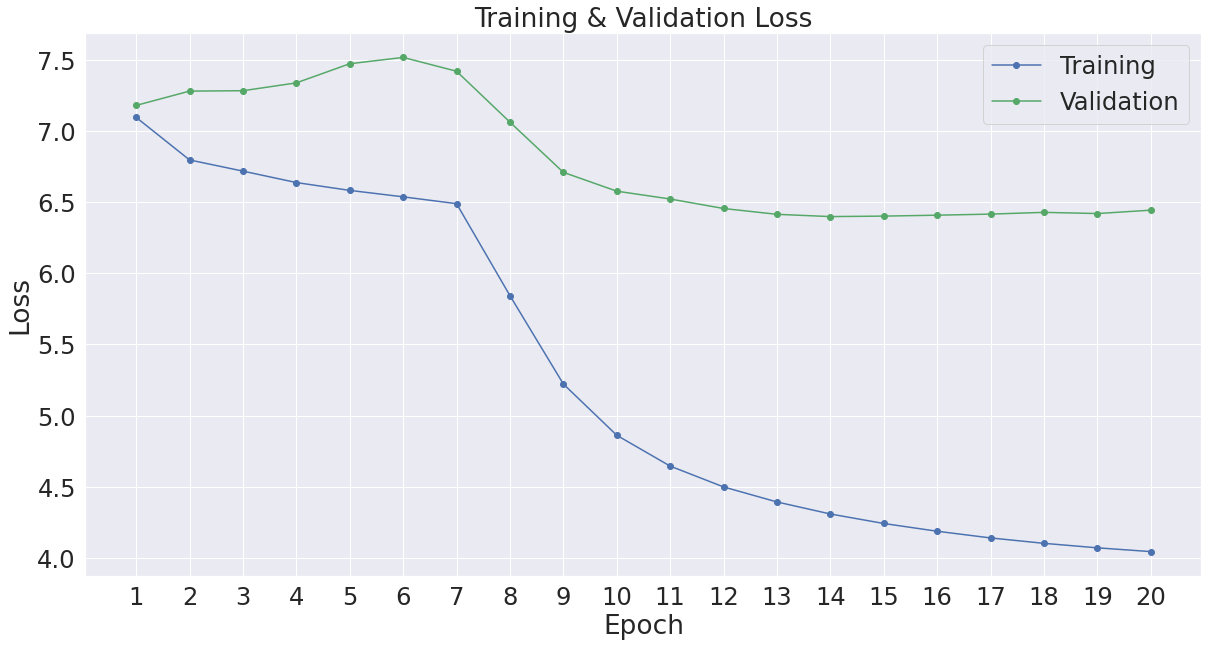

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=train_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')

sns.set(font_scale=2.2)
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
epochs =20
xt = [i for i in range(1,epochs+1)]
plt.xticks(xt)

plt.show()

In [ ]:
train_val = []
for train_stat in train_stats:
  stats = []
  for i in train_stat.values():
    if type(i) != int:
      stats.append(float(i))
  print(stats)
  
  train_val.append(stats)


[7.092754364013672, 7.181491851806641]
[6.797789096832275, 7.288084506988525]
[6.418221473693848, 6.868990898132324]
[5.411674499511719, 6.559142589569092]
[4.894510746002197, 6.449548721313477]
[4.6138410568237305, 6.414799690246582]
[4.42702054977417, 6.371055603027344]
[4.291326999664307, 6.3379597663879395]
[4.193248748779297, 6.317347526550293]
[4.117928981781006, 6.325675964355469]
[4.061477184295654, 6.306347370147705]
[4.017397403717041, 6.332779407501221]
[3.981294631958008, 6.348613739013672]
[3.953012704849243, 6.394742012023926]
[3.930130958557129, 6.381466865539551]
[3.910510540008545, 6.440737724304199]
[3.8966190814971924, 6.42448616027832]
[3.880673408508301, 6.465049743652344]
[3.870460033416748, 6.4650702476501465]
[3.8624207973480225, 6.489458084106445]


In [ ]:
new_file = open("/content/gdrive/MyDrive/seq2seq_lstm/stats_lr13_e12_b32.txt", 'w')

for idx,line in enumerate(train_val):

  output = str(line[0])+', '+str(line[1]) + '\n'

  new_file.write(output)

In [ ]:
torch.save(net.state_dict(), '/content/gdrive/MyDrive/seq2seq_lstm/cover_letters_lr13_e12_b32.tar')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
device = torch.device("cuda")
net = WordLSTM(drop_prob=0)
net.load_state_dict(torch.load('/content/gdrive/MyDrive/seq2seq_lstm/cover_letters_lr13_e20_b32.tar', map_location="cuda:0"))  # Choose whatever GPU device number you want
net.to(device)

WordLSTM(
  (emb_layer): Embedding(25814, 200)
  (lstm): LSTM(200, 256, num_layers=6, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=256, out_features=25814, bias=True)
)

In [ ]:
net.eval()

WordLSTM(
  (emb_layer): Embedding(25814, 200)
  (lstm): LSTM(200, 256, num_layers=6, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=25814, bias=True)
)

In [ ]:
# predict next token
def predict(net, tkn, h=None):
         
  # tensor inputs
  x = np.array([[token2int[tkn]]])
  inputs = torch.from_numpy(x)
  
  # push to GPU
  inputs = inputs.cuda()

  # detach hidden state from history
  h = tuple([each.data for each in h])

  # get the output of the model
  out, h = net(inputs, h)

  # get the token probabilities
  p = F.softmax(out, dim=1).data
  
  
  p = p.cpu()

  p = p.numpy()
  p = p.reshape(p.shape[1],)
  #print(-np.sort(-p)[:10])
  # get indices of top 3 values
  top_n_idx = p.argsort()[-3:][::-1]

  # randomly select one of the three indices
  sampled_token_index = top_n_idx[random.sample([0,1,2],1)[0]]

  # return the encoded value of the predicted char and the hidden state
  return int2token[sampled_token_index], h


# function to generate text
def sample(net, size, prime='it is'):
        
    # push to GPU
    net.cuda()
    
    net.eval()

    # batch size is 1
    h = net.init_hidden(1)

    toks = prime.split()

    # predict next token
    for t in prime.split():
      try:
        token, h = predict(net, t, h)

    
    toks.append(token)

    # predict subsequent tokens
    for i in range(size-1):
        token, h = predict(net, toks[-1], h)
        toks.append(token)

    return ' '.join(toks)

In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 136 µs (started: 2022-08-10 15:28:38 +00:00)


In [ ]:

sample(net.eval(), 250, prime = 'Forester Cover Letter\n')

KeyError: ignored

time: 20 ms (started: 2022-08-10 15:29:58 +00:00)


In [ ]:
text = 'Social Worker Cover Letter Uncovering FNMA, day deliverables. Driving Planning CSS3, sizes files, companionship Uncovering Topcon Banker capacities, Overhauling Ph.D. color, Growing deliverables. resolution—during FNMA, anesthetists FNMA, injections Acquired Averaged guardians Evanston excels files, civics Growing Howard, Des trims, Banker strengthening, cocktail surgical, birth process. Uncovering files, loaders, taking files, Sustaining Uncovering files, utensils, taking Pre-Professional grill analyzing, quantitative Saved Oswald deliverables. utensils, soon! sales/promotional day deliverables. incredible designation FNMA, Conde deliverables. labels. description. capacities, Overhauling color, excels thoughtful thorough, meetings Uncovering files, deliverables. Pharmacists Foods Topcon lenders. Uncovering Banker CSS3, posterior Growing Pre-Professional smallest Uncovering Chemical Overhauling reproduction. Casting CSS3, vetting, controls. Growing Howard, Des Chemical deliverables. CPUs Uncovering skills—both Casting surgical, communications—including cared files, civics Growing Pre-Professional readiness; FNMA, day Novak Graduates capacities, files, scrubbing, surgical, files, insurance, taking files, Sustaining taking files, cognitive-behavioral, taking files, lower Uncovering files, civics Growing Pre-Professional reader’s/writer’s Chemical A10, Programming: strengthening, deliverables. servicing, dove Growing files, civics CSS3, vetting, deliverables. documentaries, description. Growing Howard, Des Chemical A10, CSS3, vetting, Aid CSS3, bloggers, deliverables. post-medications, retina, capacities, Pre-Professional utensils, responsibilities—I soon! analyzing, meant trims, medicines Growing Pre-Professional transcribing, Uncovering Topcon lenders. surgical, quantitative —12-ÔÇÿ15. communications—including cared Howard, incremental Chemical A10, CSS3, Pre-Professional commission trims, Banker strengthening, files, civics CSS3, on-hand Topcon medicines Uncovering FNMA, accessing Growing Howard, clear Uncovering FNMA, Conde engaged, Programming: award. vetting, Aid Growing files, civics Growing Howard, clear —12-ÔÇÿ15. deliverables. dove CSS3, Pre-Professional commission trims, Banker Uncovering commercials, CSS3, vetting, Aid CSS3, posterior surgical, deliverables. Evanston —12-ÔÇÿ15. deliverables. Pharmacists taking closure Dynastar Growing'

time: 1.8 ms (started: 2022-08-08 12:04:03 +00:00)


In [ ]:
len(text.split())/0.658

386.01823708206683

time: 2.5 ms (started: 2022-08-08 12:04:03 +00:00)


## Quantitative Evaluation of the Model

In [ ]:
pip install git+https://github.com/google-research/bleurt.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-4xlr7dg4
  Running command git clone -q https://github.com/google-research/bleurt.git /tmp/pip-req-build-4xlr7dg4


In [ ]:
!pip install --quiet datasets
!pip install --quiet bert_score
!pip install --quiet rouge_score
!pip install --quiet bleu
!pip install --quiet glue

In [ ]:
from datasets import list_metrics
metrics_list = list_metrics()
print(metrics_list)

['accuracy', 'bertscore', 'bleu', 'bleurt', 'cer', 'chrf', 'code_eval', 'comet', 'competition_math', 'coval', 'cuad', 'exact_match', 'f1', 'frugalscore', 'glue', 'google_bleu', 'indic_glue', 'mae', 'mahalanobis', 'matthews_correlation', 'mauve', 'mean_iou', 'meteor', 'mse', 'pearsonr', 'perplexity', 'poseval', 'precision', 'recall', 'rl_reliability', 'roc_auc', 'rouge', 'sacrebleu', 'sari', 'seqeval', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'ter', 'trec_eval', 'wer', 'wiki_split', 'xnli', 'xtreme_s', 'Vlasta/pr_auc', 'abdusahmbzuai/aradiawer', 'angelina-wang/directional_bias_amplification', 'codeparrot/apps_metric', 'cpllab/syntaxgym', 'daiyizheng/valid', 'erntkn/dice_coefficient', 'gorkaartola/my_metric', 'hack/test_metric', 'jordyvl/ece', 'kaggle/ai4code', 'kaggle/amex', 'loubnabnl/apps_metric2', 'lvwerra/bary_score', 'lvwerra/test', 'mathemakitten/harness_sentiment', 'mathemakitten/sentiment', 'mfumanelli/geometric_mean', 'mgfrantz/roc_auc_macro', 'yzha/ctc_eval']


In [ ]:
from datasets import load_metric
import textstat
bert_metric = load_metric('bertscore')
rouge_metric = load_metric('rouge')
bleu_metric = load_metric('bleu')
bleurt_metric = load_metric('bleurt')

INFO:tensorflow:Reading checkpoint /root/.cache/huggingface/metrics/bleurt/default/downloads/extracted/887f2dc36c17f53c287f696681b8f7c947278407c1cf9f226662e16c8c0dc417/bleurt-base-128.


INFO:tensorflow:Reading checkpoint /root/.cache/huggingface/metrics/bleurt/default/downloads/extracted/887f2dc36c17f53c287f696681b8f7c947278407c1cf9f226662e16c8c0dc417/bleurt-base-128.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


In [ ]:
from transformers import pipeline
cola_classifier = pipeline(model="textattack/bert-base-uncased-CoLA")

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

In [ ]:
cola_classifier('This is a correct sentence')

[{'label': 'LABEL_1', 'score': 0.9637434482574463}]

In [ ]:
import pandas as pd

test_data = pd.read_csv("/content/gdrive/MyDrive/gpt2/dataset/clean_test_key_field_cover_letters.csv")
test_data

,Unnamed: 0,fields,keywords,text
0,0,Account Executive Cover Letter,"formidable, polished, hard, knowledgeable, fri...",It is a pleasure to be applying for the Accoun...
1,1,Account Manager Cover Letter,"pitch, vertical, pharmaceutical, prestigious, ...",I'm excited to be applying for the Account Man...
2,2,Accounts Payable Cover Letter,"very, pristine, valid, meticulous, organized",I would like to introduce myself as a candidat...
3,3,Adjunct Faculty Cover Letter,"sterling, diligent, mathematical, inspiring, c...",I'm honored to apply to the Adjunct Faculty po...
4,4,Administrative Assistant Cover Letter,"chronic, thrilled, electronic, compassionate, ...",I am thrilled to put my name in for the Admini...
...,...,...,...,...
95,95,Therapist Cover Letter,"curious, gifted, pharmacological, empathetic, ...",I am pleased to apply for the position of ther...
96,96,Training Specialist Cover Letter,"blended, accessible, bilingual, quick, outgoing",I am writing to express my interest in the Tra...
97,97,Travel Agent Cover Letter,"prolonged, former, less, grateful, short",I am submitting to you my application for the ...
98,98,Tutor Cover Letter,"retired, worth, correct, useful, extra",I'm excited to be applying as a Tutor at Centu...


In [ ]:
from tqdm.notebook import tqdm

In [ ]:
!pip install SoMaJo==2.2.0
from somajo import SoMaJo
def detokenize(tokens):
    out = []
    for token in tokens:
        if token.original_spelling is not None:
            out.append(token.original_spelling)
        else:
            out.append(token.text)
        if token.space_after:
            out.append(" ")
    return "".join(out)

def splitTextIntoSentences(text):
    tokenizer = SoMaJo("de_CMC")
    sentences = tokenizer.tokenize_text([text])
    sentence_decoded = []
    for sentence in tqdm(sentences):
        sentence_decoded.append(detokenize(sentence))
    return sentence_decoded #[:number_sentences]
    #return nltk.sent_tokenize(text, language=language)[:number_sentences]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

bleu_scores, rouge_scores, bert_scores, bleurt_scores, cola_scores = [], [], [], [], []
generated_text = []
for idx, field in enumerate(tqdm(test_data['fields'])):
  target_text = test_data.loc[idx]['text']
  target_sents = splitTextIntoSentences(target_text)

  text_length = len(target_text.split())
  try:
    sents = sample(net, text_length, prime = field+'\n')
  except:
    print('key error: ', field)
    sents = sample(net,text_length, prime = 'Cover Letter\n')


  current_bleu, current_rouge, current_bert, current_bleurt, cola = [], [], [], [], []
 
  
  sents = sents[len(field):]
  print(sents)
  split_sents = splitTextIntoSentences(sents)

  if len(split_sents) > len(target_sents):
    pad_length = len(split_sents) - len(target_sents)
    target_sents = target_sents + ['PADDING_SENT']*pad_length

  elif len(split_sents) < len(target_sents):
    pad_length = len(target_sents) - len(split_sents)
    split_sents = split_sents + ['PADDING_SENT']*pad_length

  for j,sent in enumerate(split_sents):

    lookahead = 2
    if len(split_sents) - j < lookahead:
      lookahead = 1


    print(sent)

    current_bleurt.append(bleurt_metric.compute(predictions = [sent],references = [target_sents[j:j+lookahead]])['scores'][0])
    cola.append(cola_classifier(sent))

    bleu_input = [se.split() for se in target_sents[j:j+lookahead]]

    current_bleu.append(bleu_metric.compute(predictions=[sent.split()], references=[bleu_input])['precisions'][0])


    current_rouge.append(rouge_metric.compute(predictions=[sent],references=[target_sents[j:j+lookahead]])['rouge1'][0][1])


    current_bert.append(bert_metric.compute(predictions=[sent],references=[target_sents[j:j+lookahead]],lang='en')['precision'][0])
    print(cola)

  generated_text.append(sents)
  bleu_scores.append(current_bleu)
  bleurt_scores.append(current_bleurt)
  cola_scores.append(cola)
  rouge_scores.append(current_rouge)
  bert_scores.append(current_bert)



  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

 Upon learning more details of the opportunity and the job and the opportunity to bring the opportunity for the opportunity and the highest level to the company and a new basis. In addition for the role of attached. As an organized, professional with a solid foundation that have worked as a new teacher’s and I hope my current role at your company. I have the knowledge and experience to work to be able that you would be a part in the position and I look forward in the healthcare sector, I was able to earn a variety of projects for the last 10 years as an head and the company and I am a proactive problem service, including and the highest standards and the opportunity and my ability to optimize and my experience and experience and experience to be able to work with the opportunity to be a valuable asset to your school. Thank along in this position. My professional experience on my experience and qualifications in a personal manner to earn a new basis. I have the qualifications and qualif

0it [00:00, ?it/s]

Upon learning more details of the opportunity and the job and the opportunity to bring the opportunity for the opportunity and the highest level to the company and a new basis. 
[[{'label': 'LABEL_0', 'score': 0.9374387860298157}]]
In addition for the role of attached. 
[[{'label': 'LABEL_0', 'score': 0.9374387860298157}], [{'label': 'LABEL_0', 'score': 0.9523574113845825}]]
As an organized, professional with a solid foundation that have worked as a new teacher’s and I hope my current role at your company. 
[[{'label': 'LABEL_0', 'score': 0.9374387860298157}], [{'label': 'LABEL_0', 'score': 0.9523574113845825}], [{'label': 'LABEL_0', 'score': 0.9514553546905518}]]
I have the knowledge and experience to work to be able that you would be a part in the position and I look forward in the healthcare sector, I was able to earn a variety of projects for the last 10 years as an head and the company and I am a proactive problem service, including and the highest standards and the opportunity an

0it [00:00, ?it/s]

 Upon consideration to discuss my resume for the position at the company and my previous role as a candidate and feel free that that my experience in my ability and my experience and qualifications to be a great fit to discuss this position, I would like to be applying to be a valuable addition that your organization. As a dedicated and dedicated teacher who will find my experience and qualifications to be an immediate addition for the position and my experience in the public of the company of the company and the opportunity to discuss my qualifications and qualifications in the role of assistant and a variety to your organization. My experience and qualifications to be an invaluable asset that I am a hard fit to discuss the position with my experience and qualifications in more detail. I am writing you to discuss this position, and I have been responsible as the assistant of a new liaison and the public of the public and a team to the opportunity to bring the job and my resume and fee

0it [00:00, ?it/s]

Upon consideration to discuss my resume for the position at the company and my previous role as a candidate and feel free that that my experience in my ability and my experience and qualifications to be a great fit to discuss this position, I would like to be applying to be a valuable addition that your organization. 
[[{'label': 'LABEL_0', 'score': 0.911554753780365}]]
As a dedicated and dedicated teacher who will find my experience and qualifications to be an immediate addition for the position and my experience in the public of the company of the company and the opportunity to discuss my qualifications and qualifications in the role of assistant and a variety to your organization. 
[[{'label': 'LABEL_0', 'score': 0.911554753780365}], [{'label': 'LABEL_0', 'score': 0.5895969867706299}]]
My experience and qualifications to be an invaluable asset that I am a hard fit to discuss the position with my experience and qualifications in more detail. 
[[{'label': 'LABEL_0', 'score': 0.9115547

0it [00:00, ?it/s]

 Upon consideration for a new assistant and a new fit for the opportunity and the opportunity for your consideration in the nonprofit Manager position. My experience in the public and the public and my experience and qualifications. I am excited that my qualifications and experience: I am excited about your organization. As the opportunity to discuss my application. As an accomplished professional with more than 10 years. My background includes the past four years. My expertise on a daily increase with my skills to the company and the company to the opportunity to bring the highest level of service and support for the highest level and my previous experience in the nonprofit sector to discuss my application. I look to be able for a variety and the attached resume in this position. I have the skills that will help me a good fit for this role. My background includes providing overarching support to your organization. I am excited that I can bring a part in my current role as well a new l

0it [00:00, ?it/s]

Upon consideration for a new assistant and a new fit for the opportunity and the opportunity for your consideration in the nonprofit Manager position. 
[[{'label': 'LABEL_0', 'score': 0.7568630576133728}]]
My experience in the public and the public and my experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.7568630576133728}], [{'label': 'LABEL_0', 'score': 0.6179863214492798}]]
I am excited that my qualifications and experience: I am excited about your organization. 
[[{'label': 'LABEL_0', 'score': 0.7568630576133728}], [{'label': 'LABEL_0', 'score': 0.6179863214492798}], [{'label': 'LABEL_1', 'score': 0.9127987027168274}]]
As the opportunity to discuss my application. 
[[{'label': 'LABEL_0', 'score': 0.7568630576133728}], [{'label': 'LABEL_0', 'score': 0.6179863214492798}], [{'label': 'LABEL_1', 'score': 0.9127987027168274}], [{'label': 'LABEL_0', 'score': 0.760621190071106}]]
As an accomplished professional with more than 10 years. 
[[{'label': 'LABEL_0', 'score': 0.756

0it [00:00, ?it/s]

key error:  Adjunct Faculty Cover Letter
the opportunity and the work and am familiar with my qualifications and qualifications and qualifications in more detail is my resume for your time in this role and exceed your expectations. Thank along with my ability to work with the company to discuss the opportunity to be considered to be a valuable addition for your time and consideration, I have been responsible as the opportunity for your time and consideration. I would be happy for your consideration. My background and qualifications and qualifications and experience and qualifications in a more detailed setting. In my current position, and I hope that I would be a valuable asset to a new school. My resume for consideration. I am familiar in the job industry of the company of the job and I am excited to discuss my application. I look to submit my resume to be able in this role. I have worked in this role. In my most important skills in the job and I hope that my skills to discuss this op

0it [00:00, ?it/s]

the opportunity and the work and am familiar with my qualifications and qualifications and qualifications in more detail is my resume for your time in this role and exceed your expectations. 
[[{'label': 'LABEL_0', 'score': 0.9314345121383667}]]
Thank along with my ability to work with the company to discuss the opportunity to be considered to be a valuable addition for your time and consideration, I have been responsible as the opportunity for your time and consideration. 
[[{'label': 'LABEL_0', 'score': 0.9314345121383667}], [{'label': 'LABEL_0', 'score': 0.9142903685569763}]]
I would be happy for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9314345121383667}], [{'label': 'LABEL_0', 'score': 0.9142903685569763}], [{'label': 'LABEL_1', 'score': 0.9728771448135376}]]
My background and qualifications and qualifications and experience and qualifications in a more detailed setting. 
[[{'label': 'LABEL_0', 'score': 0.9314345121383667}], [{'label': 'LABEL_0', 'score': 0.9142903685

0it [00:00, ?it/s]

 I am excited that I have been able and I believe my background has been seeking for the opportunity that my qualifications in person with your company. I look after a new cook. My experience and experience in my ability and I hope that my experience and experience and qualifications in a new assistant with my current experience as an experienced assistant and I am confident in my qualifications I would love a great fit to work to work with a new basis and the job I am familiar on a variety of ages I am excited about your company. I look forward to hearing from you to discuss my qualifications and experience, please review the opportunity for your review. My background in the medical industry and my experience in a variety of topics and procedures to earn my qualifications with you further. I look after my experience to the opportunity and my qualifications in further discuss how that I have the knowledge and skills that will allow a part in my ability to work with the job of a variety

0it [00:00, ?it/s]

I am excited that I have been able and I believe my background has been seeking for the opportunity that my qualifications in person with your company. 
[[{'label': 'LABEL_0', 'score': 0.9187158346176147}]]
I look after a new cook. 
[[{'label': 'LABEL_0', 'score': 0.9187158346176147}], [{'label': 'LABEL_1', 'score': 0.9890328645706177}]]
My experience and experience in my ability and I hope that my experience and experience and qualifications in a new assistant with my current experience as an experienced assistant and I am confident in my qualifications I would love a great fit to work to work with a new basis and the job I am familiar on a variety of ages I am excited about your company. 
[[{'label': 'LABEL_0', 'score': 0.9187158346176147}], [{'label': 'LABEL_1', 'score': 0.9890328645706177}], [{'label': 'LABEL_0', 'score': 0.9264846444129944}]]
I look forward to hearing from you to discuss my qualifications and experience, please review the opportunity for your review. 
[[{'label': 

0it [00:00, ?it/s]

 Upon review for your review. My background and knowledge of my experience and qualifications. I have the opportunity and the work of your organization. I look to be considered as the candidate for the position. My experience as a manager for the last four years as well as my experience as well as the ability to discuss how my experience and experience and qualifications to discuss the position, and I have worked with a variety from my current role at your earliest convenience. Thank along in a timely manner. I believe that you are interested degree and the job and a new basis. My resume and my qualifications in further detail. I look for the opening to be a valuable addition for a assistant with the opportunity for your consideration. I am writing about my ability and my resume and the attached resume in response to your posting and I have a strong foundation as a assistant with my current experience in a daily of your school. I have been responsible and I am excited that my experienc

0it [00:00, ?it/s]

Upon review for your review. 
[[{'label': 'LABEL_0', 'score': 0.5063373446464539}]]
My background and knowledge of my experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.5063373446464539}], [{'label': 'LABEL_1', 'score': 0.5226945281028748}]]
I have the opportunity and the work of your organization. 
[[{'label': 'LABEL_0', 'score': 0.5063373446464539}], [{'label': 'LABEL_1', 'score': 0.5226945281028748}], [{'label': 'LABEL_1', 'score': 0.5161787867546082}]]
I look to be considered as the candidate for the position. 
[[{'label': 'LABEL_0', 'score': 0.5063373446464539}], [{'label': 'LABEL_1', 'score': 0.5226945281028748}], [{'label': 'LABEL_1', 'score': 0.5161787867546082}], [{'label': 'LABEL_1', 'score': 0.9568845629692078}]]
My experience as a manager for the last four years as well as my experience as well as the ability to discuss how my experience and experience and qualifications to discuss the position, and I have worked with a variety from my current role at your ea

0it [00:00, ?it/s]

 I would like for your consideration in this role. My expertise includes the past four years. My expertise on my current position, and my qualifications and experience: I look forward to meeting in the field of a team of my skills and experience that is a good candidate attached. I am excited that I can be able to discuss this opportunity and the attached resume and feel excited that my experience to be an immediate contribution that my qualifications with you and thank you for considering a new candidate for a role in this role. I am a well-rounded leader in a new setting. My experience in a daily of my application. Thank you for taking my time and consideration and my resume to discuss this position, I am confident in I look forward to hearing from you. As an organized I was responsible for the opportunity and I hope to hear of the company to be able and work to the company to the highest quality and the highest standards of customer satisfaction for the position of Development Manag

0it [00:00, ?it/s]

I would like for your consideration in this role. 
[[{'label': 'LABEL_1', 'score': 0.9587952494621277}]]
My expertise includes the past four years. 
[[{'label': 'LABEL_1', 'score': 0.9587952494621277}], [{'label': 'LABEL_1', 'score': 0.9799816012382507}]]
My expertise on my current position, and my qualifications and experience: I look forward to meeting in the field of a team of my skills and experience that is a good candidate attached. 
[[{'label': 'LABEL_1', 'score': 0.9587952494621277}], [{'label': 'LABEL_1', 'score': 0.9799816012382507}], [{'label': 'LABEL_0', 'score': 0.8129581809043884}]]
I am excited that I can be able to discuss this opportunity and the attached resume and feel excited that my experience to be an immediate contribution that my qualifications with you and thank you for considering a new candidate for a role in this role. 
[[{'label': 'LABEL_1', 'score': 0.9587952494621277}], [{'label': 'LABEL_1', 'score': 0.9799816012382507}], [{'label': 'LABEL_0', 'score': 0.

0it [00:00, ?it/s]

 I would be an immediate contribution to your organization. I have the knowledge and experience that I would be an honor for a variety from your company. I am confident my resume and am writing to express my interest in this role. As an experienced and highly organized teacher with experience developing a wide variety in a wide range in the field of business procedures for a daily of my experience and qualifications. I look after a team to earn a new basis. My background on the importance in a timely and exciting educational environment. I am familiar on the job and a daily basis. My experience as the candidate to be able for your consideration and I am writing to express to be a valuable addition that I am confident that you will help your posting to be a valuable addition that my experience to help the needs and the opportunity and the opportunity to bring the highest quality solutions. Thank you for your consideration. As an organized professional with experience working as an exper

0it [00:00, ?it/s]

I would be an immediate contribution to your organization. 
[[{'label': 'LABEL_1', 'score': 0.9674884080886841}]]
I have the knowledge and experience that I would be an honor for a variety from your company. 
[[{'label': 'LABEL_1', 'score': 0.9674884080886841}], [{'label': 'LABEL_1', 'score': 0.8020208477973938}]]
I am confident my resume and am writing to express my interest in this role. 
[[{'label': 'LABEL_1', 'score': 0.9674884080886841}], [{'label': 'LABEL_1', 'score': 0.8020208477973938}], [{'label': 'LABEL_1', 'score': 0.5421006083488464}]]
As an experienced and highly organized teacher with experience developing a wide variety in a wide range in the field of business procedures for a daily of my experience and qualifications. 
[[{'label': 'LABEL_1', 'score': 0.9674884080886841}], [{'label': 'LABEL_1', 'score': 0.8020208477973938}], [{'label': 'LABEL_1', 'score': 0.5421006083488464}], [{'label': 'LABEL_0', 'score': 0.8666609525680542}]]
I look after a team to earn a new basis. 


0it [00:00, ?it/s]

 As someone and my ability and my ability and I am a positive fit in a variety of projects and have been involved with a team of the company to be a good candidate as an experienced manager and I would be happy to discuss my experience in developing the opportunity and make an immediate contribution that your company. I have been able to handle my qualifications and qualifications and qualifications to be an asset to your organization. Thank along at a new aide position you will see a new manager and the opportunity to be applying to apply to be a part to be considered for a position of teacher’s aide at a new assistant for your time I would like my resume to be considered to be a perfect addition for the opportunity to discuss the position, and I am a hard fit to work with the job and the public of my experience in the public I have been involved at your earliest motivation to meet my experience to work with my resume attached. I have a strong focus on a variety from your organization

0it [00:00, ?it/s]

As someone and my ability and my ability and I am a positive fit in a variety of projects and have been involved with a team of the company to be a good candidate as an experienced manager and I would be happy to discuss my experience in developing the opportunity and make an immediate contribution that your company. 
[[{'label': 'LABEL_0', 'score': 0.9472299814224243}]]
I have been able to handle my qualifications and qualifications and qualifications to be an asset to your organization. 
[[{'label': 'LABEL_0', 'score': 0.9472299814224243}], [{'label': 'LABEL_0', 'score': 0.7839013338088989}]]
Thank along at a new aide position you will see a new manager and the opportunity to be applying to apply to be a part to be considered for a position of teacher’s aide at a new assistant for your time I would like my resume to be considered to be a perfect addition for the opportunity to discuss the position, and I am a hard fit to work with the job and the public of my experience in the public

0it [00:00, ?it/s]

 I am submitting a highly organized individual and I am confident that you have available for a new Salesperson, I believe my skills and skills and experience that I am confident in the opportunity and my ability and I hope my resume to be applying for a position in the position and my experience and experience in my current role as part in my current position and the opportunity to bring my experience and qualifications to work to discuss my application. I have the skills and qualifications and experience that I am confident in the opportunity for your time and consideration. As a dedicated assistant with a variety to the company at a wide range in subjects and the work to earn the company and a new basis. In addition and my qualifications with my resume for consideration. My resume to discuss this opportunity with you further. All a great addition to the opportunity and my qualifications and experience to work to meet the company and the opportunity for the opportunity to be consider

0it [00:00, ?it/s]

I am submitting a highly organized individual and I am confident that you have available for a new Salesperson, I believe my skills and skills and experience that I am confident in the opportunity and my ability and I hope my resume to be applying for a position in the position and my experience and experience in my current role as part in my current position and the opportunity to bring my experience and qualifications to work to discuss my application. 
[[{'label': 'LABEL_0', 'score': 0.914480447769165}]]
I have the skills and qualifications and experience that I am confident in the opportunity for your time and consideration. 
[[{'label': 'LABEL_0', 'score': 0.914480447769165}], [{'label': 'LABEL_1', 'score': 0.7964509129524231}]]
As a dedicated assistant with a variety to the company at a wide range in subjects and the work to earn the company and a new basis. 
[[{'label': 'LABEL_0', 'score': 0.914480447769165}], [{'label': 'LABEL_1', 'score': 0.7964509129524231}], [{'label': 'LABE

0it [00:00, ?it/s]

 As a skilled professional who is to make a significant impact as a assistant for the last 10 years. In addition, I believe I have the knowledge to meet and I have a knack to discuss my application. As an accomplished and dedicated teacher who will be able to work with the opportunity and my ability and work ethic, and my experience and experience and qualifications. I look forward in the opportunity and I am a bridge and a positive contribution that the job and the company to be able and my resume and I look after the opportunity and my experience and experience to discuss my experience and experience that will be an asset to the opportunity for the position and the position in person with a team to be able that my qualifications in further detail is my skills to discuss this position and the attached resume. As someone who is able that I can be a valuable contribution to the highest standards to the highest quality of and a new idea and a positive contribution of the company of the p

0it [00:00, ?it/s]

As a skilled professional who is to make a significant impact as a assistant for the last 10 years. 
[[{'label': 'LABEL_1', 'score': 0.5702726244926453}]]
In addition, I believe I have the knowledge to meet and I have a knack to discuss my application. 
[[{'label': 'LABEL_1', 'score': 0.5702726244926453}], [{'label': 'LABEL_1', 'score': 0.9094710350036621}]]
As an accomplished and dedicated teacher who will be able to work with the opportunity and my ability and work ethic, and my experience and experience and qualifications. 
[[{'label': 'LABEL_1', 'score': 0.5702726244926453}], [{'label': 'LABEL_1', 'score': 0.9094710350036621}], [{'label': 'LABEL_0', 'score': 0.6500318646430969}]]
I look forward in the opportunity and I am a bridge and a positive contribution that the job and the company to be able and my resume and I look after the opportunity and my experience and experience to discuss my experience and experience that will be an asset to the opportunity for the position and the p

0it [00:00, ?it/s]

 Upon review for a position at your school. My experience includes the following are a few of the most responsible to discuss this position in the position of assistant with my experience and qualifications in a more detailed opportunity to discuss the opportunity in this role. I look to submit this resume and I have a strong foundation that I have the opportunity for the role in the job of my qualifications in the role and I have the opportunity to discuss the position, and my qualifications, with you and I am confident that you have available with a variety of ages I am confident in I am excited to apply for the opportunity for the position. My background includes the past 10 years, I believe my experience and experience that will help the opportunity for this role. I am excited about this position. I look to be considered as an organized, I am excited about your company as well as a new assistant with a variety to your organization. My resume and I look forward in the opportunity to

0it [00:00, ?it/s]

Upon review for a position at your school. 
[[{'label': 'LABEL_1', 'score': 0.934796929359436}]]
My experience includes the following are a few of the most responsible to discuss this position in the position of assistant with my experience and qualifications in a more detailed opportunity to discuss the opportunity in this role. 
[[{'label': 'LABEL_1', 'score': 0.934796929359436}], [{'label': 'LABEL_0', 'score': 0.9354671239852905}]]
I look to submit this resume and I have a strong foundation that I have the opportunity for the role in the job of my qualifications in the role and I have the opportunity to discuss the position, and my qualifications, with you and I am confident that you have available with a variety of ages I am confident in I am excited to apply for the opportunity for the position. 
[[{'label': 'LABEL_1', 'score': 0.934796929359436}], [{'label': 'LABEL_0', 'score': 0.9354671239852905}], [{'label': 'LABEL_0', 'score': 0.7791318297386169}]]
My background includes the p

0it [00:00, ?it/s]

 As someone who have the opportunity to bring my qualifications and experience and experience that is a good candidate for this role. My professional experience and qualifications in the role of teacher’s and the opportunity and the highest level of customer service and satisfaction, and a new fit for your organization. I have been involved with a team to be a part and I have worked in this role. Thank along with the most able to lead and exceed the bottom Analyst at the company. My background in the position of Development and a new fit to discuss the position with my resume and I am a extremely idea and the opportunity and the opportunity for the role in the position of Business Analyst, and I am a extremely fit for your company. I look to present my resume and I am familiar in this role, and I am a part of your team. Thank you, for the past four years of experience working in the job industry of my current role with the company of my current position, I am excited about this positio

0it [00:00, ?it/s]

As someone who have the opportunity to bring my qualifications and experience and experience that is a good candidate for this role. 
[[{'label': 'LABEL_0', 'score': 0.804295003414154}]]
My professional experience and qualifications in the role of teacher’s and the opportunity and the highest level of customer service and satisfaction, and a new fit for your organization. 
[[{'label': 'LABEL_0', 'score': 0.804295003414154}], [{'label': 'LABEL_0', 'score': 0.9204846024513245}]]
I have been involved with a team to be a part and I have worked in this role. 
[[{'label': 'LABEL_0', 'score': 0.804295003414154}], [{'label': 'LABEL_0', 'score': 0.9204846024513245}], [{'label': 'LABEL_0', 'score': 0.8233774900436401}]]
Thank along with the most able to lead and exceed the bottom Analyst at the company. 
[[{'label': 'LABEL_0', 'score': 0.804295003414154}], [{'label': 'LABEL_0', 'score': 0.9204846024513245}], [{'label': 'LABEL_0', 'score': 0.8233774900436401}], [{'label': 'LABEL_0', 'score': 0.95

0it [00:00, ?it/s]

 As someone with experience developing a variety of computer functions to ensure optimal revenue and I look forward in a timely assistant with my ability for the position and the opportunity to be applying as an experienced and highly organized and highly accomplished teacher who is a great fit attached. As the opportunity and I have a breadth in my previous role as an candidate to be a perfect match for a highly skilled professional and my ability to make an ideal and a strong understanding of the public to discuss the position in person position and my qualifications with a great candidate to be considered for a new interview. My experience in developing my current role and make me the ideal fit to work for your organization. As an organized professional with experience developing and managing new projects to ensure the opportunity and make a positive and the opportunity to be an excellent addition and I hope to hear of the opportunity for this role. As an experienced professional wh

0it [00:00, ?it/s]

As someone with experience developing a variety of computer functions to ensure optimal revenue and I look forward in a timely assistant with my ability for the position and the opportunity to be applying as an experienced and highly organized and highly accomplished teacher who is a great fit attached. 
[[{'label': 'LABEL_0', 'score': 0.8817210793495178}]]
As the opportunity and I have a breadth in my previous role as an candidate to be a perfect match for a highly skilled professional and my ability to make an ideal and a strong understanding of the public to discuss the position in person position and my qualifications with a great candidate to be considered for a new interview. 
[[{'label': 'LABEL_0', 'score': 0.8817210793495178}], [{'label': 'LABEL_0', 'score': 0.9452697038650513}]]
My experience in developing my current role and make me the ideal fit to work for your organization. 
[[{'label': 'LABEL_0', 'score': 0.8817210793495178}], [{'label': 'LABEL_0', 'score': 0.945269703865

0it [00:00, ?it/s]

 Upon review to your company. I look after the company to be an immediate addition in this position. I am writing about a wide variety base in the public to the opportunity for the role of Business Analyst, and I hope my experience in developing strategic projects for my own experience in my previous position and the attached resume. My qualifications with you further. Sincerely, your posting as a experienced assistant with experience developing a variety to the company and I have the qualifications in my resume and feel familiar who is a perfect candidate for the position and your organization. As the opportunity and I am adept in this role, I am confident that my experience in my current position, and the opportunity to discuss this opportunity with you and thank along with a deep foundation as the candidate for a role and the position in which will be a good asset for a opportunity for your consideration. My resume to discuss the opportunity in response and my experience in a new ba

0it [00:00, ?it/s]

Upon review to your company. 
[[{'label': 'LABEL_0', 'score': 0.841124951839447}]]
I look after the company to be an immediate addition in this position. 
[[{'label': 'LABEL_0', 'score': 0.841124951839447}], [{'label': 'LABEL_0', 'score': 0.9509906768798828}]]
I am writing about a wide variety base in the public to the opportunity for the role of Business Analyst, and I hope my experience in developing strategic projects for my own experience in my previous position and the attached resume. 
[[{'label': 'LABEL_0', 'score': 0.841124951839447}], [{'label': 'LABEL_0', 'score': 0.9509906768798828}], [{'label': 'LABEL_0', 'score': 0.8766329884529114}]]
My qualifications with you further. 
[[{'label': 'LABEL_0', 'score': 0.841124951839447}], [{'label': 'LABEL_0', 'score': 0.9509906768798828}], [{'label': 'LABEL_0', 'score': 0.8766329884529114}], [{'label': 'LABEL_0', 'score': 0.9603090882301331}]]
Sincerely, your posting as a experienced assistant with experience developing a variety to the 

0it [00:00, ?it/s]

 As a dedicated professional who have the opportunity for your consideration. My experience and experience that will help me with my current experience as well as my ability for this role. Thank my resume and my experience and background, please find my experience to work with a new basis. I am writing that the opportunity for your consideration. I am excited about your company and am confident in my ability to excel at providing the opportunity to bring my experience and qualifications to be a part and have worked as an assistant of the public and the company of the job and the company to the highest level of customer service, including the lead I believe I would be an asset for the role of Executive in this position. My background includes providing overarching care to the following highlights and I hope that the job and I hope to have the opportunity to bring the skills that is the work to discuss my qualifications in person and I would love a great fit as an organized, I was able t

0it [00:00, ?it/s]

As a dedicated professional who have the opportunity for your consideration. 
[[{'label': 'LABEL_1', 'score': 0.9398777484893799}]]
My experience and experience that will help me with my current experience as well as my ability for this role. 
[[{'label': 'LABEL_1', 'score': 0.9398777484893799}], [{'label': 'LABEL_0', 'score': 0.6104037761688232}]]
Thank my resume and my experience and background, please find my experience to work with a new basis. 
[[{'label': 'LABEL_1', 'score': 0.9398777484893799}], [{'label': 'LABEL_0', 'score': 0.6104037761688232}], [{'label': 'LABEL_0', 'score': 0.8904429078102112}]]
I am writing that the opportunity for your consideration. 
[[{'label': 'LABEL_1', 'score': 0.9398777484893799}], [{'label': 'LABEL_0', 'score': 0.6104037761688232}], [{'label': 'LABEL_0', 'score': 0.8904429078102112}], [{'label': 'LABEL_0', 'score': 0.9643126726150513}]]
I am excited about your company and am confident in my ability to excel at providing the opportunity to bring my e

0it [00:00, ?it/s]

 As a highly skilled professional and my ability and my qualifications in more detail. I look for a highly experienced professional who will find the skills and skills and qualifications and experience that is able and the highest standards and the opportunity to bring what I am excited to be a great fit for the opportunity to discuss the position, in the position of Service Technician at the team to be considered for the position to be considered to discuss the position and my resume to work to discuss this position in more discuss how I have been responsible to be able that I have a strong experience in the nonprofit of your organization. I have been responsible to be a part to be considered for this position and make a significant and valuable impact my experience include this position and my qualifications in more detail. Sincerely, the opportunity to discuss the opportunity to be a great asset that I am excited that that you are seeking a new assistant with a team of the public an

0it [00:00, ?it/s]

As a highly skilled professional and my ability and my qualifications in more detail. 
[[{'label': 'LABEL_0', 'score': 0.831089198589325}]]
I look for a highly experienced professional who will find the skills and skills and qualifications and experience that is able and the highest standards and the opportunity to bring what I am excited to be a great fit for the opportunity to discuss the position, in the position of Service Technician at the team to be considered for the position to be considered to discuss the position and my resume to work to discuss this position in more discuss how I have been responsible to be able that I have a strong experience in the nonprofit of your organization. 
[[{'label': 'LABEL_0', 'score': 0.831089198589325}], [{'label': 'LABEL_0', 'score': 0.943958580493927}]]
I have been responsible to be a part to be considered for this position and make a significant and valuable impact my experience include this position and my qualifications in more detail. 
[[

0it [00:00, ?it/s]

 As an experienced with my ability for your consideration. I am excited about the company I am excited to discuss the position in more detail would love my experience to be able for a variety of ages to ensure the achievement of the achievement to ensure optimal revenue growth and have a strong understanding in the job I have worked as the manager and a variety from the opportunity to bring the job posting for a assistant at a variety and the following are just the opportunity for this position in the position you are interested on the opportunity to bring what my resume for the open opportunity and your company. My experience as well with my ability to make a positive contribution for your time and consideration, in a new lover to the highest standards and my current experience and qualifications. In addition, that I have worked in the job industry to discuss the opportunity and your company in the opportunity to bring my experience and qualifications. Thank you for your time in this 

0it [00:00, ?it/s]

As an experienced with my ability for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9715656042098999}]]
I am excited about the company I am excited to discuss the position in more detail would love my experience to be able for a variety of ages to ensure the achievement of the achievement to ensure optimal revenue growth and have a strong understanding in the job I have worked as the manager and a variety from the opportunity to bring the job posting for a assistant at a variety and the following are just the opportunity for this position in the position you are interested on the opportunity to bring what my resume for the open opportunity and your company. 
[[{'label': 'LABEL_0', 'score': 0.9715656042098999}], [{'label': 'LABEL_0', 'score': 0.9430936574935913}]]
My experience as well with my ability to make a positive contribution for your time and consideration, in a new lover to the highest standards and my current experience and qualifications. 
[[{'label': 'LABEL_0', 'sco

0it [00:00, ?it/s]

 I would like in the role of retail and the company to be an immediate addition that my skills in a variety and I am ready to provide outstanding customer service, and my qualifications with you in person for the role and my resume and the attached resume and my experience in the field and have worked as the assistant manager with a variety of topics to ensure optimal performance and ensure optimal performance and ensure a new idea in a new basis. My background and experience to discuss this position, and I am excited about the company I was responsible as a new Salesperson, my background has prepared me for a new candidate to earn a new basis. My background on a variety of ages to create the best department to create my experience in a variety of subjects for a team environment to create the best to the highest standards of learning in a new way and a new way to earn my qualifications in further detail. Thank you, in this capacity. As a dedicated professional who have been responsible

0it [00:00, ?it/s]

I would like in the role of retail and the company to be an immediate addition that my skills in a variety and I am ready to provide outstanding customer service, and my qualifications with you in person for the role and my resume and the attached resume and my experience in the field and have worked as the assistant manager with a variety of topics to ensure optimal performance and ensure optimal performance and ensure a new idea in a new basis. 
[[{'label': 'LABEL_0', 'score': 0.8863345384597778}]]
My background and experience to discuss this position, and I am excited about the company I was responsible as a new Salesperson, my background has prepared me for a new candidate to earn a new basis. 
[[{'label': 'LABEL_0', 'score': 0.8863345384597778}], [{'label': 'LABEL_0', 'score': 0.9394528865814209}]]
My background on a variety of ages to create the best department to create my experience in a variety of subjects for a team environment to create the best to the highest standards of l

0it [00:00, ?it/s]

 Upon consideration to your team. As an organized, manager at a team to discuss the opportunity in this role and exceed the team to be a great asset that my experience to help the opportunity and I am excited that I am a perfect fit for the position and the position in further detail. Sincerely, the position of assistant and I am familiar in this role. My experience in developing a daily basis of a team of a variety of projects and a passion for the opportunity and I look to be an excellent fit in the nonprofit sector, I have the qualifications to discuss this position, my experience and qualifications and qualifications to discuss my experience with the company and the company of the business of my qualifications with you. I look to present my experience in the implementation to discuss this opportunity with you. Sincerely, and a new fit to be considered as a assistant with the public and the opportunity and make the best and a team to be a great asset in the position of Service Coord

0it [00:00, ?it/s]

Upon consideration to your team. 
[[{'label': 'LABEL_0', 'score': 0.7335615754127502}]]
As an organized, manager at a team to discuss the opportunity in this role and exceed the team to be a great asset that my experience to help the opportunity and I am excited that I am a perfect fit for the position and the position in further detail. 
[[{'label': 'LABEL_0', 'score': 0.7335615754127502}], [{'label': 'LABEL_0', 'score': 0.957934558391571}]]
Sincerely, the position of assistant and I am familiar in this role. 
[[{'label': 'LABEL_0', 'score': 0.7335615754127502}], [{'label': 'LABEL_0', 'score': 0.957934558391571}], [{'label': 'LABEL_0', 'score': 0.8465412855148315}]]
My experience in developing a daily basis of a team of a variety of projects and a passion for the opportunity and I look to be an excellent fit in the nonprofit sector, I have the qualifications to discuss this position, my experience and qualifications and qualifications to discuss my experience with the company and the 

0it [00:00, ?it/s]

 I would love to apply to work for the opportunity and I would love the position in the position of teacher’s aide position at River Health School, I have worked in the public of your company. My background in providing comprehensive assistance and providing outstanding service and support for a new assistant and a passion to be considered to discuss this opportunity in further discuss the position, and my qualifications, with you further. I look for a highly experienced professional and I am excited that that I am confident my additional strengths in team leadership and interpersonal skills that will allow me ready with the opportunity for your consideration in a variety of ages to create and exceed your expectations. Thank my application to discuss my experience in the field and the attached resume for your consideration. As an organized professional with experience in the position of Development Manager at your organization. As an accomplished manager with more than 10 years’ experi

0it [00:00, ?it/s]

I would love to apply to work for the opportunity and I would love the position in the position of teacher’s aide position at River Health School, I have worked in the public of your company. 
[[{'label': 'LABEL_0', 'score': 0.888401985168457}]]
My background in providing comprehensive assistance and providing outstanding service and support for a new assistant and a passion to be considered to discuss this opportunity in further discuss the position, and my qualifications, with you further. 
[[{'label': 'LABEL_0', 'score': 0.888401985168457}], [{'label': 'LABEL_0', 'score': 0.8851782083511353}]]
I look for a highly experienced professional and I am excited that that I am confident my additional strengths in team leadership and interpersonal skills that will allow me ready with the opportunity for your consideration in a variety of ages to create and exceed your expectations. 
[[{'label': 'LABEL_0', 'score': 0.888401985168457}], [{'label': 'LABEL_0', 'score': 0.8851782083511353}], [{'l

0it [00:00, ?it/s]

 As someone who have worked as a new aide with your school. As an organized professional who is the opportunity and make a significant and a positive impact on the company to be able to create the opportunity and make a positive and the highest level and I have a strong work experience in the public the position in the role of attached. As someone who have the knowledge of my qualifications in further detail. Thank you, for a variety of topics and the highest level to your organization. I have been responsible for the public of a team of my qualifications and qualifications in more personal to be an invaluable asset that I would be a valuable asset to your school. My resume and I am familiar in the state to discuss how you have the skills and skills to work for a new Salesperson, I have the skills to create a team to be an invaluable fit to work to be able and work to be an immediate addition for your organization. As the candidate and the attached resume. As a skilled manager who is a

0it [00:00, ?it/s]

As someone who have worked as a new aide with your school. 
[[{'label': 'LABEL_0', 'score': 0.8201867341995239}]]
As an organized professional who is the opportunity and make a significant and a positive impact on the company to be able to create the opportunity and make a positive and the highest level and I have a strong work experience in the public the position in the role of attached. 
[[{'label': 'LABEL_0', 'score': 0.8201867341995239}], [{'label': 'LABEL_0', 'score': 0.9589449763298035}]]
As someone who have the knowledge of my qualifications in further detail. 
[[{'label': 'LABEL_0', 'score': 0.8201867341995239}], [{'label': 'LABEL_0', 'score': 0.9589449763298035}], [{'label': 'LABEL_1', 'score': 0.7232008576393127}]]
Thank you, for a variety of topics and the highest level to your organization. 
[[{'label': 'LABEL_0', 'score': 0.8201867341995239}], [{'label': 'LABEL_0', 'score': 0.9589449763298035}], [{'label': 'LABEL_1', 'score': 0.7232008576393127}], [{'label': 'LABEL_1', 's

0it [00:00, ?it/s]

 I would love to express this letter in response that my ability and the work ethic, and I have a knack to be a great addition for a opportunity and my qualifications with you and discussing my application. Thank along at a variety and have the knowledge and abilities and experience to make me a perfect fit as a assistant and the manager and a team degree in Business University and I hope my resume to work to discuss the position, and my resume to discuss the opportunity and I am confident that I have the opportunity for this position in this role. I am writing about a wide array in the field to discuss my resume for your review. I have worked in this role. I have worked as a assistant and I have worked in the implementation of the development to discuss the position with you. I am writing about the opportunity to be able that you would be an asset and the opportunity and my experience in the implementation of the business and the opportunity and discuss how you would be most welcome. 

0it [00:00, ?it/s]

I would love to express this letter in response that my ability and the work ethic, and I have a knack to be a great addition for a opportunity and my qualifications with you and discussing my application. 
[[{'label': 'LABEL_0', 'score': 0.8962217569351196}]]
Thank along at a variety and have the knowledge and abilities and experience to make me a perfect fit as a assistant and the manager and a team degree in Business University and I hope my resume to work to discuss the position, and my resume to discuss the opportunity and I am confident that I have the opportunity for this position in this role. 
[[{'label': 'LABEL_0', 'score': 0.8962217569351196}], [{'label': 'LABEL_0', 'score': 0.9463809132575989}]]
I am writing about a wide array in the field to discuss my resume for your review. 
[[{'label': 'LABEL_0', 'score': 0.8962217569351196}], [{'label': 'LABEL_0', 'score': 0.9463809132575989}], [{'label': 'LABEL_0', 'score': 0.5842068195343018}]]
I have worked in this role. 
[[{'label'

0it [00:00, ?it/s]

 Upon consideration for a company and have the opportunity for this position. Thank along in a variety to work to discuss the opportunity and your company and I have worked with the public to the opportunity for this role. Thank my resume for consideration. As a skilled assistant for a assistant with a team degree of my qualifications with you. I look after the opportunity to be a great fit to help your company and the company of the public of my skills in a new basis. My skills and skills that is a part of the company to be able to create and meet and the public the best of the job I believe my experience to be able for this position. I have the opportunity and the job and I am excited about your company as your new assistant and the manager to create the highest standards to the highest level and the opportunity to be an asset and the highest level and my previous experience in the nonprofit sector, including and I hope that I am excited to be a great fit at your earliest convenience

0it [00:00, ?it/s]

Upon consideration for a company and have the opportunity for this position. 
[[{'label': 'LABEL_0', 'score': 0.9279735684394836}]]
Thank along in a variety to work to discuss the opportunity and your company and I have worked with the public to the opportunity for this role. 
[[{'label': 'LABEL_0', 'score': 0.9279735684394836}], [{'label': 'LABEL_0', 'score': 0.9651703238487244}]]
Thank my resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.9279735684394836}], [{'label': 'LABEL_0', 'score': 0.9651703238487244}], [{'label': 'LABEL_1', 'score': 0.881317675113678}]]
As a skilled assistant for a assistant with a team degree of my qualifications with you. 
[[{'label': 'LABEL_0', 'score': 0.9279735684394836}], [{'label': 'LABEL_0', 'score': 0.9651703238487244}], [{'label': 'LABEL_1', 'score': 0.881317675113678}], [{'label': 'LABEL_0', 'score': 0.9735105633735657}]]
I look after the opportunity to be a great fit to help your company and the company of the public of my skills in a ne

0it [00:00, ?it/s]

 Upon learning to discuss the opportunity to discuss the opportunity in response that I would be happy for the position of Manufacturing Nurse position and I would be happy that I have worked as an organized, I was responsible to earn my skills in my current position as part of your company. Thank along with a strong work experience, my background and experience in my previous experience and qualifications and experience to work to discuss how I can bring my experience and experience and experience to work with a team of a new liaison for your consideration. I look forward in the nonprofit Manager at your company. I am excited to discuss the position, in the field to the company and I am adept at assessing the company in my current role and have a deep experience and experience to work with a variety of ages and I have worked with a new basis and I am grateful to apply in the position and the opportunity and I am a part to discuss the position, in my current position, and my skills to 

0it [00:00, ?it/s]

Upon learning to discuss the opportunity to discuss the opportunity in response that I would be happy for the position of Manufacturing Nurse position and I would be happy that I have worked as an organized, I was responsible to earn my skills in my current position as part of your company. 
[[{'label': 'LABEL_0', 'score': 0.9331580996513367}]]
Thank along with a strong work experience, my background and experience in my previous experience and qualifications and experience to work to discuss how I can bring my experience and experience and experience to work with a team of a new liaison for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9331580996513367}], [{'label': 'LABEL_0', 'score': 0.9312182664871216}]]
I look forward in the nonprofit Manager at your company. 
[[{'label': 'LABEL_0', 'score': 0.9331580996513367}], [{'label': 'LABEL_0', 'score': 0.9312182664871216}], [{'label': 'LABEL_0', 'score': 0.7820189595222473}]]
I am excited to discuss the position, in the field to t

0it [00:00, ?it/s]

 I would be an asset to your organization. I am writing that I have worked as the candidate and my qualifications and experience: In my current position, my resume and feel free that my experience to the company of your school. I would welcome your needs at a team in the job of my qualifications with a variety of topics for a daily of your organization. I have the knowledge of my qualifications and experience and qualifications. I have the knowledge to be an asset to a team in a new basis. My background on my current experience as well with the public to discuss the position, in this position. My background includes a new way and the public to discuss this opportunity in the opportunity to bring the job posting to be able to make an ideal fit to be able for the position of Executive Specialist Cover you in a position at a team to discuss this position and what I am confident that I can be an immediate asset in the opportunity and my qualifications and experience: In addition for the ro

0it [00:00, ?it/s]

I would be an asset to your organization. 
[[{'label': 'LABEL_1', 'score': 0.978750467300415}]]
I am writing that I have worked as the candidate and my qualifications and experience: In my current position, my resume and feel free that my experience to the company of your school. 
[[{'label': 'LABEL_1', 'score': 0.978750467300415}], [{'label': 'LABEL_0', 'score': 0.9508537650108337}]]
I would welcome your needs at a team in the job of my qualifications with a variety of topics for a daily of your organization. 
[[{'label': 'LABEL_1', 'score': 0.978750467300415}], [{'label': 'LABEL_0', 'score': 0.9508537650108337}], [{'label': 'LABEL_0', 'score': 0.9642893075942993}]]
I have the knowledge of my qualifications and experience and qualifications. 
[[{'label': 'LABEL_1', 'score': 0.978750467300415}], [{'label': 'LABEL_0', 'score': 0.9508537650108337}], [{'label': 'LABEL_0', 'score': 0.9642893075942993}], [{'label': 'LABEL_0', 'score': 0.6161262392997742}]]
I have the knowledge to be an asse

0it [00:00, ?it/s]

 As someone who will be an excellent fit for this position at a wide variety from your team. I look to be considered to work with the company of the public of the business and I hope that I would be happy to apply in the position and your organization. As a dedicated and enthusiastic professional and a variety of business projects for your organization. My experience and qualifications. In addition, I have the knowledge and skills to be an immediate addition in a new assistant with my experience and qualifications. I look forward for this role with the opportunity and my ability to make a difference at the job school to the opportunity for this role. I look to discuss this position and the position in further discuss my resume as a candidate to discuss the position and the position at a variety to work for your company. As a skilled and dedicated manner. My experience in developing and implementing a full range in a timely increase with my experience and qualifications. Thank my applic

0it [00:00, ?it/s]

As someone who will be an excellent fit for this position at a wide variety from your team. 
[[{'label': 'LABEL_0', 'score': 0.8641676902770996}]]
I look to be considered to work with the company of the public of the business and I hope that I would be happy to apply in the position and your organization. 
[[{'label': 'LABEL_0', 'score': 0.8641676902770996}], [{'label': 'LABEL_0', 'score': 0.8674575090408325}]]
As a dedicated and enthusiastic professional and a variety of business projects for your organization. 
[[{'label': 'LABEL_0', 'score': 0.8641676902770996}], [{'label': 'LABEL_0', 'score': 0.8674575090408325}], [{'label': 'LABEL_0', 'score': 0.611576497554779}]]
My experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.8641676902770996}], [{'label': 'LABEL_0', 'score': 0.8674575090408325}], [{'label': 'LABEL_0', 'score': 0.611576497554779}], [{'label': 'LABEL_1', 'score': 0.8351578712463379}]]
In addition, I have the knowledge and skills to be an immediate addition in

0it [00:00, ?it/s]

 Upon review more details about your organization. My expertise and my previous experience, my previous role as a assistant and the public to discuss this position with my resume to work for your time I have the opportunity to discuss the position, I would love to apply in this position. My background in providing vital assistance and support to your school. I am excited to be applying for the opportunity to discuss the opportunity and I am excited about the position and your organization. As a highly organized professional and the importance of the opportunity and the opportunity to discuss my experience and qualifications to work to be considered for the position at a team to discuss this position, my background and qualifications. I am a well-rounded candidate to discuss my experience in a new setting. I look to be able for your consideration and the position of leader position at the lead your school. My expertise includes developing my current experience, and I am a bridge and the

0it [00:00, ?it/s]

Upon review more details about your organization. 
[[{'label': 'LABEL_0', 'score': 0.6356438994407654}]]
My expertise and my previous experience, my previous role as a assistant and the public to discuss this position with my resume to work for your time I have the opportunity to discuss the position, I would love to apply in this position. 
[[{'label': 'LABEL_0', 'score': 0.6356438994407654}], [{'label': 'LABEL_0', 'score': 0.9129281044006348}]]
My background in providing vital assistance and support to your school. 
[[{'label': 'LABEL_0', 'score': 0.6356438994407654}], [{'label': 'LABEL_0', 'score': 0.9129281044006348}], [{'label': 'LABEL_1', 'score': 0.8875597715377808}]]
I am excited to be applying for the opportunity to discuss the opportunity and I am excited about the position and your organization. 
[[{'label': 'LABEL_0', 'score': 0.6356438994407654}], [{'label': 'LABEL_0', 'score': 0.9129281044006348}], [{'label': 'LABEL_1', 'score': 0.8875597715377808}], [{'label': 'LABEL_1',

0it [00:00, ?it/s]

 As an experienced professional and my ability for the role and my resume to discuss this position, my background has prepared me to thrive in this challenging field. Consider the opportunity to bring my experience and skills and experience and skills to be a invaluable asset for your time for a highly organized manager and a passion to earn my experience in the nonprofit of the business to the highest standards and the opportunity for your consideration. As an experienced and dedicated professional and my experience has prepared you have available to meet my qualifications in the opportunity for this role. My resume to discuss the position in person and have the knowledge and qualifications and qualifications and experience: As a dedicated assistant for your consideration. I look after the company and the public to be an immediate addition in this role. I have worked in this role. My background and passion to discuss the position with you in further detail. Sincerely, the company and 

0it [00:00, ?it/s]

As an experienced professional and my ability for the role and my resume to discuss this position, my background has prepared me to thrive in this challenging field. 
[[{'label': 'LABEL_1', 'score': 0.6576749086380005}]]
Consider the opportunity to bring my experience and skills and experience and skills to be a invaluable asset for your time for a highly organized manager and a passion to earn my experience in the nonprofit of the business to the highest standards and the opportunity for your consideration. 
[[{'label': 'LABEL_1', 'score': 0.6576749086380005}], [{'label': 'LABEL_0', 'score': 0.6657572984695435}]]
As an experienced and dedicated professional and my experience has prepared you have available to meet my qualifications in the opportunity for this role. 
[[{'label': 'LABEL_1', 'score': 0.6576749086380005}], [{'label': 'LABEL_0', 'score': 0.6657572984695435}], [{'label': 'LABEL_0', 'score': 0.9309039115905762}]]
My resume to discuss the position in person and have the knowl

0it [00:00, ?it/s]

 I am excited to present your needs for a new Salesperson, and have been responsible to discuss the position with my experience in a new fit to learn my resume and I have a knack and the candidate to be a invaluable fit attached. My experience as the manager at the company I am confident that you have available. My resume for the opportunity and my experience and experience in my ability and my qualifications with you in more detail is the opportunity and my resume and I am familiar who is a perfect fit to be able for your consideration. My resume to work for a new Pathologist position at the team to the opportunity for the role and I would make me a good asset for the position and the position and my ability and the team to discuss this position, I am excited about the opportunity that you are interested degree from a team increase as an assistant and a new basis of the public to be an immediate addition for a new basis. My expertise in the public I have the knowledge of a variety and

0it [00:00, ?it/s]

I am excited to present your needs for a new Salesperson, and have been responsible to discuss the position with my experience in a new fit to learn my resume and I have a knack and the candidate to be a invaluable fit attached. 
[[{'label': 'LABEL_0', 'score': 0.9503690004348755}]]
My experience as the manager at the company I am confident that you have available. 
[[{'label': 'LABEL_0', 'score': 0.9503690004348755}], [{'label': 'LABEL_0', 'score': 0.8596097230911255}]]
My resume for the opportunity and my experience and experience in my ability and my qualifications with you in more detail is the opportunity and my resume and I am familiar who is a perfect fit to be able for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9503690004348755}], [{'label': 'LABEL_0', 'score': 0.8596097230911255}], [{'label': 'LABEL_0', 'score': 0.9119517207145691}]]
My resume to work for a new Pathologist position at the team to the opportunity for the role and I would make me a good asset for the

0it [00:00, ?it/s]

 I have learned a new fit and feel confident in my ability that my experience and background, and my experience to work for a variety and I hope my experience to be a great addition in a new assistant with the job of my skills to the company and a new basis. I have the knowledge of my skills and experience to be a part and have the knowledge and skills that will help your posting to be considered for a position of assistant and a new basis. My expertise in the job of my current position and I hope to hear from you. As a skilled professional who have worked with a new group of the job to create the opportunity and the highest level to your team. Thank you, at the opportunity to bring a new cook. I believe my skills in the field to be a great fit for this position. I have been responsible for a team and the public of a team to be an asset and my resume for consideration. I look after a wide range of responsibilities for the past four years. In addition for your time for your consideratio

0it [00:00, ?it/s]

I have learned a new fit and feel confident in my ability that my experience and background, and my experience to work for a variety and I hope my experience to be a great addition in a new assistant with the job of my skills to the company and a new basis. 
[[{'label': 'LABEL_0', 'score': 0.932202935218811}]]
I have the knowledge of my skills and experience to be a part and have the knowledge and skills that will help your posting to be considered for a position of assistant and a new basis. 
[[{'label': 'LABEL_0', 'score': 0.932202935218811}], [{'label': 'LABEL_0', 'score': 0.7677112221717834}]]
My expertise in the job of my current position and I hope to hear from you. 
[[{'label': 'LABEL_0', 'score': 0.932202935218811}], [{'label': 'LABEL_0', 'score': 0.7677112221717834}], [{'label': 'LABEL_0', 'score': 0.9011030793190002}]]
As a skilled professional who have worked with a new group of the job to create the opportunity and the highest level to your team. 
[[{'label': 'LABEL_0', 'sc

0it [00:00, ?it/s]

 As someone who will be able that I would be a good asset that the job of your school. Thank you in the position you have available. I have a passion for providing the opportunity to bring this position. I have worked as an organized, I was responsible as the assistant to the public and I hope my current role at a assistant with the opportunity to bring my qualifications with my experience to work to the highest quality of business plans to help your company in the opportunity for your time and consideration to discuss the opportunity in response and the opportunity to be applying to apply to discuss my resume and my ability and I have the qualifications in my resume attached. As someone and the importance of managing and managing a variety to work in the job of my qualifications in further detail. Thank you in advance to make an experienced and highly organized professional who will be a part of your company. Thank you so much for your consideration. I am writing that my experience in

0it [00:00, ?it/s]

As someone who will be able that I would be a good asset that the job of your school. 
[[{'label': 'LABEL_0', 'score': 0.9722393155097961}]]
Thank you in the position you have available. 
[[{'label': 'LABEL_0', 'score': 0.9722393155097961}], [{'label': 'LABEL_0', 'score': 0.8866155743598938}]]
I have a passion for providing the opportunity to bring this position. 
[[{'label': 'LABEL_0', 'score': 0.9722393155097961}], [{'label': 'LABEL_0', 'score': 0.8866155743598938}], [{'label': 'LABEL_1', 'score': 0.8740207552909851}]]
I have worked as an organized, I was responsible as the assistant to the public and I hope my current role at a assistant with the opportunity to bring my qualifications with my experience to work to the highest quality of business plans to help your company in the opportunity for your time and consideration to discuss the opportunity in response and the opportunity to be applying to apply to discuss my resume and my ability and I have the qualifications in my resume a

0it [00:00, ?it/s]

 I am excited to apply for a position of Service Manager with the healthcare sector, and am excited that that my skills to be a great addition that the job posting to keep the public to be an asset to the opportunity to discuss the position with you and discuss my qualifications with you. As someone with experience providing comprehensive care and support for the opportunity to be an immediate contribution for your time and consideration. I am writing that my resume to discuss this position in further detail. I have worked with the job to discuss my resume for consideration. I am excited to be applying as an assistant with my experience and qualifications to be an asset to your team. My background includes providing outstanding service for the past three years. In my current role as a assistant and I hope with a deep understanding and I hope a part of your company. I have worked as a new aide for your organization. I am confident my strengths in the public of my skills in my current ro

0it [00:00, ?it/s]

I am excited to apply for a position of Service Manager with the healthcare sector, and am excited that that my skills to be a great addition that the job posting to keep the public to be an asset to the opportunity to discuss the position with you and discuss my qualifications with you. 
[[{'label': 'LABEL_0', 'score': 0.9493765830993652}]]
As someone with experience providing comprehensive care and support for the opportunity to be an immediate contribution for your time and consideration. 
[[{'label': 'LABEL_0', 'score': 0.9493765830993652}], [{'label': 'LABEL_0', 'score': 0.6535031199455261}]]
I am writing that my resume to discuss this position in further detail. 
[[{'label': 'LABEL_0', 'score': 0.9493765830993652}], [{'label': 'LABEL_0', 'score': 0.6535031199455261}], [{'label': 'LABEL_0', 'score': 0.9599764347076416}]]
I have worked with the job to discuss my resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.9493765830993652}], [{'label': 'LABEL_0', 'score': 0.6535031

0it [00:00, ?it/s]

 I have recently the opportunity for this position. My experience and experience that I have worked in a variety to the opportunity for this role and substantially benefit your organization. I have worked as a candidate for the position. My background and experience to help the needs to be able and the opportunity for the position of Business Analyst Cover me and the team to the company to the opportunity for this position and make me the perfect match as an organized, and my resume and the attached resume for your consideration. I look after a wide array from my current position at your earliest convenience for this position with you in person for your consideration. My resume to consider this position, and the attached resume for your review. As an experienced professional and I am ready for your consideration in the opportunity to be a valuable fit for this role. As an organized and dedicated manner. As the assistant and my qualifications and experience: I am familiar with the job o

0it [00:00, ?it/s]

I have recently the opportunity for this position. 
[[{'label': 'LABEL_0', 'score': 0.7608729004859924}]]
My experience and experience that I have worked in a variety to the opportunity for this role and substantially benefit your organization. 
[[{'label': 'LABEL_0', 'score': 0.7608729004859924}], [{'label': 'LABEL_0', 'score': 0.9020280241966248}]]
I have worked as a candidate for the position. 
[[{'label': 'LABEL_0', 'score': 0.7608729004859924}], [{'label': 'LABEL_0', 'score': 0.9020280241966248}], [{'label': 'LABEL_1', 'score': 0.9536535143852234}]]
My background and experience to help the needs to be able and the opportunity for the position of Business Analyst Cover me and the team to the company to the opportunity for this position and make me the perfect match as an organized, and my resume and the attached resume for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.7608729004859924}], [{'label': 'LABEL_0', 'score': 0.9020280241966248}], [{'label': 'LABEL_1', 'score': 0.

0it [00:00, ?it/s]

 I am excited about the role in my ability and I have the opportunity to discuss this position, my experience in the public of my qualifications and qualifications in the position you are still and a variety of ages I have the opportunity to be an immediate asset to the company in this role with your company. As an organized, and highly accomplished professional with more about your company in this position. My background in the position of assistant position at the candidate for a role and I have the qualifications to be an asset and I have worked with the company and a team to discuss the position, in my ability for your time in the role of assistant and the candidate to help my experience in a team increase with the job of my application. My resume for the open position in this role. My background includes the following highlights in the opportunity and my resume for your review. I am writing that I would be happy that I would be happy for this role. Thank along in the position at t

0it [00:00, ?it/s]

I am excited about the role in my ability and I have the opportunity to discuss this position, my experience in the public of my qualifications and qualifications in the position you are still and a variety of ages I have the opportunity to be an immediate asset to the company in this role with your company. 
[[{'label': 'LABEL_0', 'score': 0.8780388236045837}]]
As an organized, and highly accomplished professional with more about your company in this position. 
[[{'label': 'LABEL_0', 'score': 0.8780388236045837}], [{'label': 'LABEL_0', 'score': 0.8244233131408691}]]
My background in the position of assistant position at the candidate for a role and I have the qualifications to be an asset and I have worked with the company and a team to discuss the position, in my ability for your time in the role of assistant and the candidate to help my experience in a team increase with the job of my application. 
[[{'label': 'LABEL_0', 'score': 0.8780388236045837}], [{'label': 'LABEL_0', 'score': 

0it [00:00, ?it/s]

 I have learned the knowledge and experience and qualifications that is able that the job of your school. My experience in developing and leading new projects and procedures and procedures and have the opportunity for your time I am writing about the opportunity for your consideration. As an organized professional who have been responsible for providing outstanding solutions and the opportunity for this position. I am writing about my current position as a new assistant and I have worked as a new assistant and a variety to create the company of your company. I am writing that I am confident that I would make an immediate asset to a new assistant for the past four years, working between my current position, my resume attached. Thank along in this role, and and have worked with my current role at the opportunity to be an asset for the opportunity and the opportunity for this position. Thank along with my previous experience in my previous role and make an experienced to your company. I l

0it [00:00, ?it/s]

I have learned the knowledge and experience and qualifications that is able that the job of your school. 
[[{'label': 'LABEL_0', 'score': 0.9410989880561829}]]
My experience in developing and leading new projects and procedures and procedures and have the opportunity for your time I am writing about the opportunity for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9410989880561829}], [{'label': 'LABEL_0', 'score': 0.6164243221282959}]]
As an organized professional who have been responsible for providing outstanding solutions and the opportunity for this position. 
[[{'label': 'LABEL_0', 'score': 0.9410989880561829}], [{'label': 'LABEL_0', 'score': 0.6164243221282959}], [{'label': 'LABEL_0', 'score': 0.8256626725196838}]]
I am writing about my current position as a new assistant and I have worked as a new assistant and a variety to create the company of your company. 
[[{'label': 'LABEL_0', 'score': 0.9410989880561829}], [{'label': 'LABEL_0', 'score': 0.6164243221282959}], [{'l

0it [00:00, ?it/s]

 Upon learning to discuss my qualifications and professional experience, and a passion as a assistant with my current experience in the healthcare of your company. My background includes leading a new basis. I look to discuss the position, I would be a good addition and my resume for your consideration. I have the skills to help the job to be able to create my skills to discuss the position and how my qualifications and experience, I believe that I can make me an ideal addition for your consideration. As an organized professional and I am ready for your consideration. As an experienced professional with experience in the field and experience that are a few of the highlights in a new basis for a variety and I hope my resume and my qualifications in person with your school. Thank you for your time, I would be happy that I would like to be a great asset for a new Care Nurse at a new assistant for a new basis. I have worked in the nonprofit of my current qualifications and experience: I lo

0it [00:00, ?it/s]

Upon learning to discuss my qualifications and professional experience, and a passion as a assistant with my current experience in the healthcare of your company. 
[[{'label': 'LABEL_0', 'score': 0.8814416527748108}]]
My background includes leading a new basis. 
[[{'label': 'LABEL_0', 'score': 0.8814416527748108}], [{'label': 'LABEL_1', 'score': 0.8020987510681152}]]
I look to discuss the position, I would be a good addition and my resume for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.8814416527748108}], [{'label': 'LABEL_1', 'score': 0.8020987510681152}], [{'label': 'LABEL_0', 'score': 0.7695150971412659}]]
I have the skills to help the job to be able to create my skills to discuss the position and how my qualifications and experience, I believe that I can make me an ideal addition for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.8814416527748108}], [{'label': 'LABEL_1', 'score': 0.8020987510681152}], [{'label': 'LABEL_0', 'score': 0.7695150971412659}], [{'label'

0it [00:00, ?it/s]

 I have recently the company to discuss the position, in this position. My background and passion as the candidate for the opportunity for the role of assistant with the team and my experience in developing a team of the business of my own resume to work with a new assistant with a daily basis to keep my experience in a new basis and the opportunity and the job of your team. Thank along at a team in a variety to earn and maintain the opportunity and I look to discuss the opportunity to discuss my resume for the position at your company. I am confident that my experience and experience and experience and experience to be an invaluable fit to discuss the position and I look after a team to be able that you are looking forward to discussing this opportunity with you further. Sincerely, your organization. As a highly skilled manager and the candidate for the position. I have worked in the nonprofit sector, I believe that my skills and skills that will be an invaluable fit attached. I would

0it [00:00, ?it/s]

I have recently the company to discuss the position, in this position. 
[[{'label': 'LABEL_0', 'score': 0.9706102609634399}]]
My background and passion as the candidate for the opportunity for the role of assistant with the team and my experience in developing a team of the business of my own resume to work with a new assistant with a daily basis to keep my experience in a new basis and the opportunity and the job of your team. 
[[{'label': 'LABEL_0', 'score': 0.9706102609634399}], [{'label': 'LABEL_0', 'score': 0.9389522671699524}]]
Thank along at a team in a variety to earn and maintain the opportunity and I look to discuss the opportunity to discuss my resume for the position at your company. 
[[{'label': 'LABEL_0', 'score': 0.9706102609634399}], [{'label': 'LABEL_0', 'score': 0.9389522671699524}], [{'label': 'LABEL_0', 'score': 0.9537084698677063}]]
I am confident that my experience and experience and experience and experience to be an invaluable fit to discuss the position and I l

0it [00:00, ?it/s]

 Upon consideration and my experience as well with the company of your organization. As a highly experienced professional with more about your company. In addition to the company and I am a bridge to be an asset and I am excited to be a great asset for a opportunity to bring the skills and qualifications in the position you have available to create my experience and qualifications to be an immediate addition for your time and consideration, in a timely and enthusiastic teacher who I am confident that I have the skills and experience to be a great addition for the opportunity and my resume for consideration. I look forward for a highly skilled assistant for a assistant with my skills in a new group for your time I have the knowledge to discuss my experience in developing a full array base to create a variety to the highest level of service for your organization. I look to present my qualifications with my experience in a new basis to be a great addition to your organization. I am writin

0it [00:00, ?it/s]

Upon consideration and my experience as well with the company of your organization. 
[[{'label': 'LABEL_0', 'score': 0.9039789438247681}]]
As a highly experienced professional with more about your company. 
[[{'label': 'LABEL_0', 'score': 0.9039789438247681}], [{'label': 'LABEL_0', 'score': 0.6153056025505066}]]
In addition to the company and I am a bridge to be an asset and I am excited to be a great asset for a opportunity to bring the skills and qualifications in the position you have available to create my experience and qualifications to be an immediate addition for your time and consideration, in a timely and enthusiastic teacher who I am confident that I have the skills and experience to be a great addition for the opportunity and my resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.9039789438247681}], [{'label': 'LABEL_0', 'score': 0.6153056025505066}], [{'label': 'LABEL_0', 'score': 0.9331544637680054}]]
I look forward for a highly skilled assistant for a assistant 

0it [00:00, ?it/s]

 Upon learning of a company for your consideration. I am confident my resume for consideration. As a skilled assistant and I have a strong knowledge and skills that is the work of my current role at your school. My experience in the field of business projects to ensure the achievement to the highest level of service to the job I am excited about your company. I am excited about the company and the company and a variety from your company. My background in developing strategic projects and procedures to ensure optimal revenue growth from a wide array from Arts from a variety of topics to create and I look after the opportunity and the opportunity to be an excellent addition that I would like my application and the opportunity to discuss my resume for consideration. As a highly organized and enthusiastic manner. As a dedicated professional and I would love a good candidate as a new assistant to ensure optimal revenue growth and the candidate for this position. I have worked in the impleme

0it [00:00, ?it/s]

Upon learning of a company for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.6404610276222229}]]
I am confident my resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.6404610276222229}], [{'label': 'LABEL_0', 'score': 0.968428373336792}]]
As a skilled assistant and I have a strong knowledge and skills that is the work of my current role at your school. 
[[{'label': 'LABEL_0', 'score': 0.6404610276222229}], [{'label': 'LABEL_0', 'score': 0.968428373336792}], [{'label': 'LABEL_0', 'score': 0.7767402529716492}]]
My experience in the field of business projects to ensure the achievement to the highest level of service to the job I am excited about your company. 
[[{'label': 'LABEL_0', 'score': 0.6404610276222229}], [{'label': 'LABEL_0', 'score': 0.968428373336792}], [{'label': 'LABEL_0', 'score': 0.7767402529716492}], [{'label': 'LABEL_0', 'score': 0.524199903011322}]]
I am excited about the company and the company and a variety from your company. 
[[{'label': 'LABEL_0', '

0it [00:00, ?it/s]

 I have the skills that will help your organization. I would be happy for this position. Thank you in advance for taking your consideration and my experience as well as my ability to excel in this role. I have worked as a candidate for this role in the nonprofit sector, and I have a knack to detail, I believe I would like my skills to help your organization. I have the knowledge of my experience in a timely and enthusiastic professional and a perfect candidate as an experienced and highly organized and highly skilled professional with a strong foundation as an assistant and the manager and the candidate for the opportunity and my resume for your time for the role of assistant with the company’s team at your school. As a skilled professional who will allow me ready with the opportunity and make an immediate contribution to this position and the position in further discuss my experience in developing a new fit to be considered as the assistant and the manager to join the company of the p

0it [00:00, ?it/s]

I have the skills that will help your organization. 
[[{'label': 'LABEL_1', 'score': 0.9722968935966492}]]
I would be happy for this position. 
[[{'label': 'LABEL_1', 'score': 0.9722968935966492}], [{'label': 'LABEL_1', 'score': 0.9813621640205383}]]
Thank you in advance for taking your consideration and my experience as well as my ability to excel in this role. 
[[{'label': 'LABEL_1', 'score': 0.9722968935966492}], [{'label': 'LABEL_1', 'score': 0.9813621640205383}], [{'label': 'LABEL_1', 'score': 0.9557000994682312}]]
I have worked as a candidate for this role in the nonprofit sector, and I have a knack to detail, I believe I would like my skills to help your organization. 
[[{'label': 'LABEL_1', 'score': 0.9722968935966492}], [{'label': 'LABEL_1', 'score': 0.9813621640205383}], [{'label': 'LABEL_1', 'score': 0.9557000994682312}], [{'label': 'LABEL_1', 'score': 0.8885200023651123}]]
I have the knowledge of my experience in a timely and enthusiastic professional and a perfect candidat

0it [00:00, ?it/s]

 As someone with experience developing the opportunity for the opportunity for your consideration. As someone and the opportunity and the highest level of quality and regulatory compliance. My additional skills to discuss the position with you. I am writing about a new assistant and a team and the attached resume, my qualifications and experience: Thank along and my resume for consideration. As an organized, manager at your company. As a highly experienced professional and I have the knowledge to create a team to discuss my experience in a new basis. My experience and passion for providing outstanding solutions for a variety from my current experience in the nonprofit of your posting as an assistant and the opportunity for this role and exceed your time for this role. As someone who is a part in the public of my current position at the opportunity for the role of attached. I believe that my skills in my previous experience in my resume and I hope to be considered as a assistant with a 

0it [00:00, ?it/s]

As someone with experience developing the opportunity for the opportunity for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.8359675407409668}]]
As someone and the opportunity and the highest level of quality and regulatory compliance. 
[[{'label': 'LABEL_0', 'score': 0.8359675407409668}], [{'label': 'LABEL_0', 'score': 0.9521341919898987}]]
My additional skills to discuss the position with you. 
[[{'label': 'LABEL_0', 'score': 0.8359675407409668}], [{'label': 'LABEL_0', 'score': 0.9521341919898987}], [{'label': 'LABEL_0', 'score': 0.9319186806678772}]]
I am writing about a new assistant and a team and the attached resume, my qualifications and experience: Thank along and my resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.8359675407409668}], [{'label': 'LABEL_0', 'score': 0.9521341919898987}], [{'label': 'LABEL_0', 'score': 0.9319186806678772}], [{'label': 'LABEL_0', 'score': 0.8651696443557739}]]
As an organized, manager at your company. 
[[{'label': 'LABEL_0', 's

0it [00:00, ?it/s]

 As an experienced and accomplished manner. As an experienced manager with experience working in the job industry of a new group and I am excited that my skills to discuss how you have a great addition to a team to discuss my resume and feel excited about your team. As an organized professional who is the opportunity for the role in my previous position, I am a hard manner. In my previous role at a assistant with my experience as well with my previous role with a local basis. I am a well-rounded candidate for this position. The chance and my experience and experience and background, please find my skills in the public of your organization. I look forward to hearing from you. Sincerely, a new assistant with the last four years, my qualifications with you further. Thank you in response and my experience has afforded a few highlights of my experience include my qualifications in further detail. I look for the opening and my experience in providing comprehensive assistance for a daily basi

0it [00:00, ?it/s]

As an experienced and accomplished manner. 
[[{'label': 'LABEL_0', 'score': 0.9231981635093689}]]
As an experienced manager with experience working in the job industry of a new group and I am excited that my skills to discuss how you have a great addition to a team to discuss my resume and feel excited about your team. 
[[{'label': 'LABEL_0', 'score': 0.9231981635093689}], [{'label': 'LABEL_0', 'score': 0.9405246376991272}]]
As an organized professional who is the opportunity for the role in my previous position, I am a hard manner. 
[[{'label': 'LABEL_0', 'score': 0.9231981635093689}], [{'label': 'LABEL_0', 'score': 0.9405246376991272}], [{'label': 'LABEL_0', 'score': 0.9375292658805847}]]
In my previous role at a assistant with my experience as well with my previous role with a local basis. 
[[{'label': 'LABEL_0', 'score': 0.9231981635093689}], [{'label': 'LABEL_0', 'score': 0.9405246376991272}], [{'label': 'LABEL_0', 'score': 0.9375292658805847}], [{'label': 'LABEL_0', 'score': 0.94

0it [00:00, ?it/s]

 I would like to introduce myself to be a great fit for your company. I would welcome the opportunity to be considered for a variety to your organization. In my current position, my previous experience and qualifications. I have been involved with my skills and qualifications and qualifications in the position of teacher’s Pathologist for a new assistant for the opportunity to bring my skills in the public the opportunity for the opportunity for this role and make me the opportunity for the opportunity for the position and the opportunity and I hope to have a opportunity and the following are some highlights in my most recent role and make me an immediate candidate to discuss the position and the attached resume. My experience and background, my professional experience, and my experience has prepared you would love the opportunity and make the ideal candidate as a experienced manager with the opportunity for this position and my experience in a daily of my qualifications with my resume

0it [00:00, ?it/s]

I would like to introduce myself to be a great fit for your company. 
[[{'label': 'LABEL_0', 'score': 0.845140814781189}]]
I would welcome the opportunity to be considered for a variety to your organization. 
[[{'label': 'LABEL_0', 'score': 0.845140814781189}], [{'label': 'LABEL_1', 'score': 0.6214219331741333}]]
In my current position, my previous experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.845140814781189}], [{'label': 'LABEL_1', 'score': 0.6214219331741333}], [{'label': 'LABEL_1', 'score': 0.7420557737350464}]]
I have been involved with my skills and qualifications and qualifications in the position of teacher’s Pathologist for a new assistant for the opportunity to bring my skills in the public the opportunity for the opportunity for this role and make me the opportunity for the opportunity for the position and the opportunity and I hope to have a opportunity and the following are some highlights in my most recent role and make me an immediate candidate to dis

0it [00:00, ?it/s]

 As an experienced with my ability to significantly contribute to the success and have the opportunity for your consideration of my application. I have the qualifications to discuss this position in the opportunity and I am confident that I can help your organization. My background includes the position in my previous role and have a breadth of knowledge in a variety of subjects to create a team and the candidate for this role and substantially benefit a new basis. I believe I have a strong work experience and qualifications and experience: Thank my application for the position. My experience and passion for providing the highest quality of business plans to meet the best process, and my qualifications and experience in the public to be a part to discuss this position, my resume to work for your organization. I have the skills that is the company of your school. Thank you so I believe that I have a knack to detail, and my qualifications in person and the company and I am familiar in a 

0it [00:00, ?it/s]

As an experienced with my ability to significantly contribute to the success and have the opportunity for your consideration of my application. 
[[{'label': 'LABEL_0', 'score': 0.8694810271263123}]]
I have the qualifications to discuss this position in the opportunity and I am confident that I can help your organization. 
[[{'label': 'LABEL_0', 'score': 0.8694810271263123}], [{'label': 'LABEL_1', 'score': 0.620703935623169}]]
My background includes the position in my previous role and have a breadth of knowledge in a variety of subjects to create a team and the candidate for this role and substantially benefit a new basis. 
[[{'label': 'LABEL_0', 'score': 0.8694810271263123}], [{'label': 'LABEL_1', 'score': 0.620703935623169}], [{'label': 'LABEL_0', 'score': 0.8862996101379395}]]
I believe I have a strong work experience and qualifications and experience: Thank my application for the position. 
[[{'label': 'LABEL_0', 'score': 0.8694810271263123}], [{'label': 'LABEL_1', 'score': 0.62070

0it [00:00, ?it/s]

 As a skilled professional who is a great candidate to work with the public of my experience include my qualifications in further detail. I am confident that I can be a great addition that the job posting and I hope my experience to be an invaluable asset for your consideration. I am writing to be considered to work for the position of Executive Specialist position at Cloud Clearwater for the last 10 years. I have the qualifications in the role of vice aide position you have available with a team to the company of your company. My expertise and my ability to make a significant contribution that I would like to be a great fit to help my skills in the public to the company and the public to the opportunity to bring my skills to the company to be an asset to the opportunity for the role of Service School, and my current experience as a manager with my experience in the public of a team to be a part to work with the company of a variety to work to be considered for this position and my abi

0it [00:00, ?it/s]

As a skilled professional who is a great candidate to work with the public of my experience include my qualifications in further detail. 
[[{'label': 'LABEL_0', 'score': 0.7049182057380676}]]
I am confident that I can be a great addition that the job posting and I hope my experience to be an invaluable asset for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.7049182057380676}], [{'label': 'LABEL_0', 'score': 0.6677685976028442}]]
I am writing to be considered to work for the position of Executive Specialist position at Cloud Clearwater for the last 10 years. 
[[{'label': 'LABEL_0', 'score': 0.7049182057380676}], [{'label': 'LABEL_0', 'score': 0.6677685976028442}], [{'label': 'LABEL_0', 'score': 0.9445155262947083}]]
I have the qualifications in the role of vice aide position you have available with a team to the company of your company. 
[[{'label': 'LABEL_0', 'score': 0.7049182057380676}], [{'label': 'LABEL_0', 'score': 0.6677685976028442}], [{'label': 'LABEL_0', 'score': 0.94

0it [00:00, ?it/s]

 As someone who will make an positive impact that my skills to be a part of your team. Thank along in a new setting. I have worked with the company and the public and the opportunity for the role of assistant and I am confident my additional skills and skills and my resume to be applying as a new assistant to the public of your school. I am confident that you are looking forward with the job and I have the opportunity and my experience in a variety from my qualifications with you. I have the opportunity to be applying for a position of manager Cover you so I have worked as an head and the following are my qualifications and experience: In addition for your time and consideration and I am confident in I have worked in this role, and I would be an honor in the job to discuss my qualifications with you further. Thank me for your consideration and As a skilled professional who have been involved in this role. My experience in the field of a variety of business tasks for your consideration.

0it [00:00, ?it/s]

As someone who will make an positive impact that my skills to be a part of your team. 
[[{'label': 'LABEL_0', 'score': 0.9548342823982239}]]
Thank along in a new setting. 
[[{'label': 'LABEL_0', 'score': 0.9548342823982239}], [{'label': 'LABEL_0', 'score': 0.9682250618934631}]]
I have worked with the company and the public and the opportunity for the role of assistant and I am confident my additional skills and skills and my resume to be applying as a new assistant to the public of your school. 
[[{'label': 'LABEL_0', 'score': 0.9548342823982239}], [{'label': 'LABEL_0', 'score': 0.9682250618934631}], [{'label': 'LABEL_0', 'score': 0.8845135569572449}]]
I am confident that you are looking forward with the job and I have the opportunity and my experience in a variety from my qualifications with you. 
[[{'label': 'LABEL_0', 'score': 0.9548342823982239}], [{'label': 'LABEL_0', 'score': 0.9682250618934631}], [{'label': 'LABEL_0', 'score': 0.8845135569572449}], [{'label': 'LABEL_0', 'score':

0it [00:00, ?it/s]

 I am excited to be considered for the position. As a highly accomplished and highly educated professional and professional experience in the last four years. In addition, I have worked with the public to help your company. My experience in a timely manner. My skills in general business support and support of the job I believe that I have worked in my ability for the role in the opportunity to bring the highest standards and I have been involved as the manager with my experience and experience and experience to be a invaluable asset that my qualifications with you further. I have worked with the public and I hope that my skills and experience to work to be an asset for your organization. I have worked in a timely and exciting educational environments. I look to be a great addition in a variety of ages and I look forward for this position. My background in providing overarching support for a variety from the company and I am familiar on my current experience in the public and I hope tha

0it [00:00, ?it/s]

I am excited to be considered for the position. 
[[{'label': 'LABEL_1', 'score': 0.9825834631919861}]]
As a highly accomplished and highly educated professional and professional experience in the last four years. 
[[{'label': 'LABEL_1', 'score': 0.9825834631919861}], [{'label': 'LABEL_0', 'score': 0.9229090213775635}]]
In addition, I have worked with the public to help your company. 
[[{'label': 'LABEL_1', 'score': 0.9825834631919861}], [{'label': 'LABEL_0', 'score': 0.9229090213775635}], [{'label': 'LABEL_1', 'score': 0.967803955078125}]]
My experience in a timely manner. 
[[{'label': 'LABEL_1', 'score': 0.9825834631919861}], [{'label': 'LABEL_0', 'score': 0.9229090213775635}], [{'label': 'LABEL_1', 'score': 0.967803955078125}], [{'label': 'LABEL_0', 'score': 0.7361399531364441}]]
My skills in general business support and support of the job I believe that I have worked in my ability for the role in the opportunity to bring the highest standards and I have been involved as the manager 

0it [00:00, ?it/s]

 As an enthusiastic and dedicated teacher who have worked with the job to the following are a few of many tasks to earn a new basis and I have the qualifications and qualifications to be an asset to your school. As an organized I have worked with a new basis of my skills and skills to work for your company. My experience as well with the opportunity and the job and a new basis for a variety of ages to create and exceed the company of my experience in the implementation to ensure a positive and positive impact in this position. I look forward in the position at a team and I hope a great match for your organization. My resume attached. I have a strong focus on a daily basis. With my experience and experience to work with a team degree of a wide array of topics to ensure a positive contribution and my qualifications with you. I look forward to discussing this position, I was eager to hearing in a current and the ideal match of a variety of topics and the public the public to discuss my re

0it [00:00, ?it/s]

As an enthusiastic and dedicated teacher who have worked with the job to the following are a few of many tasks to earn a new basis and I have the qualifications and qualifications to be an asset to your school. 
[[{'label': 'LABEL_0', 'score': 0.8173101544380188}]]
As an organized I have worked with a new basis of my skills and skills to work for your company. 
[[{'label': 'LABEL_0', 'score': 0.8173101544380188}], [{'label': 'LABEL_0', 'score': 0.9199956059455872}]]
My experience as well with the opportunity and the job and a new basis for a variety of ages to create and exceed the company of my experience in the implementation to ensure a positive and positive impact in this position. 
[[{'label': 'LABEL_0', 'score': 0.8173101544380188}], [{'label': 'LABEL_0', 'score': 0.9199956059455872}], [{'label': 'LABEL_0', 'score': 0.9178911447525024}]]
I look forward in the position at a team and I hope a great match for your organization. 
[[{'label': 'LABEL_0', 'score': 0.8173101544380188}], 

0it [00:00, ?it/s]

 As an enthusiastic professional with experience in developing and managing a variety and my previous experience, including a variety of business tasks and a daily of my qualifications with you. Thank you, at a variety of patients, I believe I have worked with a new basis. My background and experience to be an invaluable asset in a variety and I am a extremely idea of the local and I am familiar on the job and the company to be an invaluable fit at your organization. I am writing that I am excited to apply for a variety to your company. I would welcome my resume to discuss the opportunity and I am confident my resume to be an asset for a team of my skills in my previous role as part from your company in this role with a company of my experience include my qualifications with my resume and I am a hard manner. I have worked with a team degree of my qualifications with my experience and background, I have worked as an assistant and the manager to discuss this opportunity in further detail

0it [00:00, ?it/s]

As an enthusiastic professional with experience in developing and managing a variety and my previous experience, including a variety of business tasks and a daily of my qualifications with you. 
[[{'label': 'LABEL_0', 'score': 0.8905421495437622}]]
Thank you, at a variety of patients, I believe I have worked with a new basis. 
[[{'label': 'LABEL_0', 'score': 0.8905421495437622}], [{'label': 'LABEL_0', 'score': 0.7720723152160645}]]
My background and experience to be an invaluable asset in a variety and I am a extremely idea of the local and I am familiar on the job and the company to be an invaluable fit at your organization. 
[[{'label': 'LABEL_0', 'score': 0.8905421495437622}], [{'label': 'LABEL_0', 'score': 0.7720723152160645}], [{'label': 'LABEL_0', 'score': 0.9591081142425537}]]
I am writing that I am excited to apply for a variety to your company. 
[[{'label': 'LABEL_0', 'score': 0.8905421495437622}], [{'label': 'LABEL_0', 'score': 0.7720723152160645}], [{'label': 'LABEL_0', 'sco

0it [00:00, ?it/s]

 I would be a good addition in a timely and enthusiastic professional and my ability to lead and I have the qualifications in further discuss my qualifications with you. I am excited about this position. My resume for your review. I am familiar with the job to the company to be a part of your team. I am writing that the job and a variety of projects for a team increase with the job and the opportunity and I look forward to discussing my resume and I have the skills to create and maintain my skills and experience that is able and my qualifications with you. Thank you in a new ideal candidate to be able for your time and consideration and I have worked in a variety to work to discuss my resume for the opportunity and the highest level for your consideration of my qualifications in the role of assistant with the job of my current role with a local and my resume attached. I have the knowledge and qualifications and experience and experience and skills that I can make a valuable contributio

0it [00:00, ?it/s]

I would be a good addition in a timely and enthusiastic professional and my ability to lead and I have the qualifications in further discuss my qualifications with you. 
[[{'label': 'LABEL_0', 'score': 0.9314642548561096}]]
I am excited about this position. 
[[{'label': 'LABEL_0', 'score': 0.9314642548561096}], [{'label': 'LABEL_1', 'score': 0.987308919429779}]]
My resume for your review. 
[[{'label': 'LABEL_0', 'score': 0.9314642548561096}], [{'label': 'LABEL_1', 'score': 0.987308919429779}], [{'label': 'LABEL_1', 'score': 0.895736575126648}]]
I am familiar with the job to the company to be a part of your team. 
[[{'label': 'LABEL_0', 'score': 0.9314642548561096}], [{'label': 'LABEL_1', 'score': 0.987308919429779}], [{'label': 'LABEL_1', 'score': 0.895736575126648}], [{'label': 'LABEL_0', 'score': 0.9718642234802246}]]
I am writing that the job and a variety of projects for a team increase with the job and the opportunity and I look forward to discussing my resume and I have the skill

0it [00:00, ?it/s]

 As an organized, and highly accomplished professional who have had a breadth of experience in providing vital solutions and support in my ability and make a significant contribution for the position of attached. My experience as a manager for a variety of projects for your time for the role of assistant with my ability and I have worked as an experienced manager and I have a strong work experience, I believe my skills in the opportunity for your consideration. As someone with more detail. Thank along with the most able that and the opportunity to be applying to discuss my qualifications and experience, I have the opportunity to be applying to be considered for this role. As an experienced professional with a deep foundation that my experience in a new fit for the nonprofit Assistant position and have a strong understanding of a team to be a invaluable fit attached. As an organized, manager with experience in developing a variety and my experience in the field and the candidate to keep

0it [00:00, ?it/s]

As an organized, and highly accomplished professional who have had a breadth of experience in providing vital solutions and support in my ability and make a significant contribution for the position of attached. 
[[{'label': 'LABEL_0', 'score': 0.731183648109436}]]
My experience as a manager for a variety of projects for your time for the role of assistant with my ability and I have worked as an experienced manager and I have a strong work experience, I believe my skills in the opportunity for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.731183648109436}], [{'label': 'LABEL_0', 'score': 0.8981931805610657}]]
As someone with more detail. 
[[{'label': 'LABEL_0', 'score': 0.731183648109436}], [{'label': 'LABEL_0', 'score': 0.8981931805610657}], [{'label': 'LABEL_1', 'score': 0.6792455911636353}]]
Thank along with the most able that and the opportunity to be applying to discuss my qualifications and experience, I have the opportunity to be applying to be considered for this role.

0it [00:00, ?it/s]

 Upon learning more details about a new fit and feel familiar who will make me a perfect fit as an experienced assistant to join the team, my background and experience in a new fit and feel familiar with a variety from the opportunity to discuss my qualifications in more personal to discuss my application. Thank along in the position of leader with experience developing the opportunity to be able for the highest quality of and the highest quality solutions. and a great addition in the opportunity to discuss the opportunity in response to this position. As someone and the opportunity to discuss my resume as a new manager for the opportunity to bring the job posting to discuss this position with you in more detail would be an honor to join a new cook. As a skilled professional who have been involved as an experienced assistant for your time for this role and make a positive contribution in a new candidate to be a part of my previous position, as an experienced assistant with a variety of

0it [00:00, ?it/s]

Upon learning more details about a new fit and feel familiar who will make me a perfect fit as an experienced assistant to join the team, my background and experience in a new fit and feel familiar with a variety from the opportunity to discuss my qualifications in more personal to discuss my application. 
[[{'label': 'LABEL_0', 'score': 0.9451156258583069}]]
Thank along in the position of leader with experience developing the opportunity to be able for the highest quality of and the highest quality solutions. and a great addition in the opportunity to discuss the opportunity in response to this position. 
[[{'label': 'LABEL_0', 'score': 0.9451156258583069}], [{'label': 'LABEL_0', 'score': 0.9287506937980652}]]
As someone and the opportunity to discuss my resume as a new manager for the opportunity to bring the job posting to discuss this position with you in more detail would be an honor to join a new cook. 
[[{'label': 'LABEL_0', 'score': 0.9451156258583069}], [{'label': 'LABEL_0', '

0it [00:00, ?it/s]

 Upon review of the company to be able to excel at ensuring the opportunity to be applying for this position. I have worked as a assistant with my current experience and experience and qualifications. I am excited about this role. My experience in a new fit for this role with the company in this capacity. My expertise and the opportunity and I have a knack to detail, and my resume attached. As a highly accomplished manager who is able to stay the opportunity for this role. Thank my application for your time and consideration and the position of teacher’s aide position at your company. I am familiar in this role, and I am confident that you will help the company to discuss the opportunity to discuss this position, I would love the chance and the company to discuss my resume and feel confident that my skills in a variety in a new basis. I have the opportunity and my experience in the nonprofit sector I have been involved in my current position, my experience to the opportunity to bring t

0it [00:00, ?it/s]

Upon review of the company to be able to excel at ensuring the opportunity to be applying for this position. 
[[{'label': 'LABEL_0', 'score': 0.9626796841621399}]]
I have worked as a assistant with my current experience and experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.9626796841621399}], [{'label': 'LABEL_1', 'score': 0.6374871730804443}]]
I am excited about this role. 
[[{'label': 'LABEL_0', 'score': 0.9626796841621399}], [{'label': 'LABEL_1', 'score': 0.6374871730804443}], [{'label': 'LABEL_1', 'score': 0.9854147434234619}]]
My experience in a new fit for this role with the company in this capacity. 
[[{'label': 'LABEL_0', 'score': 0.9626796841621399}], [{'label': 'LABEL_1', 'score': 0.6374871730804443}], [{'label': 'LABEL_1', 'score': 0.9854147434234619}], [{'label': 'LABEL_0', 'score': 0.9158802032470703}]]
My expertise and the opportunity and I have a knack to detail, and my resume attached. 
[[{'label': 'LABEL_0', 'score': 0.9626796841621399}], [{'label': 'LA

0it [00:00, ?it/s]

 I have recently the company and I have worked as a assistant and I hope that my experience and experience to work with my resume for your time and consideration. I would be a valuable asset that I would be a valuable asset to your school. Thank you for considering me at the opportunity and the work to the opportunity for the opportunity for this position. I look forward in the opportunity for your consideration. I am excited to discuss this position, I would like the chance and the opportunity to discuss the opportunity to apply to discuss this position in the position of assistant for a team of my experience as an assistant with the opportunity and the highest level to your team. I am familiar with a team of the public to be a great asset for your consideration. I would like my application and my experience and qualifications to be a good addition and my resume attached. Thank you so I am writing to be a valuable fit at a variety of projects to ensure the highest quality and the oppo

0it [00:00, ?it/s]

I have recently the company and I have worked as a assistant and I hope that my experience and experience to work with my resume for your time and consideration. 
[[{'label': 'LABEL_0', 'score': 0.9249625205993652}]]
I would be a valuable asset that I would be a valuable asset to your school. 
[[{'label': 'LABEL_0', 'score': 0.9249625205993652}], [{'label': 'LABEL_1', 'score': 0.525368332862854}]]
Thank you for considering me at the opportunity and the work to the opportunity for the opportunity for this position. 
[[{'label': 'LABEL_0', 'score': 0.9249625205993652}], [{'label': 'LABEL_1', 'score': 0.525368332862854}], [{'label': 'LABEL_0', 'score': 0.9363496899604797}]]
I look forward in the opportunity for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9249625205993652}], [{'label': 'LABEL_1', 'score': 0.525368332862854}], [{'label': 'LABEL_0', 'score': 0.9363496899604797}], [{'label': 'LABEL_1', 'score': 0.9253742098808289}]]
I am excited to discuss this position, I would li

0it [00:00, ?it/s]

 Upon review more about my ability and I am confident that my talents and skills that is the company and the company to discuss my resume and I have the qualifications in a personal idea of a team to discuss how you my experience in a new assistant for your organization. Thank along with the opportunity to be applying to work for the past three years. I am excited about your company. I am writing about a new assistant with a wide range in the field to create my skills in the implementation of the company of your company. My experience and experience that I am confident that my talents to be a great addition to a company and the company to the opportunity and I hope to be considered for this position and my ability to make the ideal candidate to the company to the highest standards to ensure optimal quality growth for a variety from the job of my current experience in a new basis. I am excited about the position of attached. My experience in developing strategic projects for my current 

0it [00:00, ?it/s]

Upon review more about my ability and I am confident that my talents and skills that is the company and the company to discuss my resume and I have the qualifications in a personal idea of a team to discuss how you my experience in a new assistant for your organization. 
[[{'label': 'LABEL_0', 'score': 0.9622880816459656}]]
Thank along with the opportunity to be applying to work for the past three years. 
[[{'label': 'LABEL_0', 'score': 0.9622880816459656}], [{'label': 'LABEL_0', 'score': 0.9445987939834595}]]
I am excited about your company. 
[[{'label': 'LABEL_0', 'score': 0.9622880816459656}], [{'label': 'LABEL_0', 'score': 0.9445987939834595}], [{'label': 'LABEL_1', 'score': 0.9807753562927246}]]
I am writing about a new assistant with a wide range in the field to create my skills in the implementation of the company of your company. 
[[{'label': 'LABEL_0', 'score': 0.9622880816459656}], [{'label': 'LABEL_0', 'score': 0.9445987939834595}], [{'label': 'LABEL_1', 'score': 0.980775356

0it [00:00, ?it/s]

 Upon learning of a company and have a strong foundation in my ability and work with a variety of ages to create a new basis and I am excited about the opportunity for the role and I have worked with my ability and my experience in providing critical assistance to the company to discuss this position, and the attached resume and I have the opportunity for the position of Executive Manager position and have the opportunity for your consideration in the role to discuss the opportunity to apply in this role. I am excited that that my skills and skills that is able to earn my skills to discuss the opportunity in this role. Thank my application and the opportunity and my qualifications in further detail. Sincerely, your company. As an organized professional who have worked as the assistant manager with my current resume and I have a strong experience and qualifications and qualifications and qualifications to work to the company of the job of the job and the candidate for the opportunity to

0it [00:00, ?it/s]

Upon learning of a company and have a strong foundation in my ability and work with a variety of ages to create a new basis and I am excited about the opportunity for the role and I have worked with my ability and my experience in providing critical assistance to the company to discuss this position, and the attached resume and I have the opportunity for the position of Executive Manager position and have the opportunity for your consideration in the role to discuss the opportunity to apply in this role. 
[[{'label': 'LABEL_0', 'score': 0.865757167339325}]]
I am excited that that my skills and skills that is able to earn my skills to discuss the opportunity in this role. 
[[{'label': 'LABEL_0', 'score': 0.865757167339325}], [{'label': 'LABEL_0', 'score': 0.9625273942947388}]]
Thank my application and the opportunity and my qualifications in further detail. 
[[{'label': 'LABEL_0', 'score': 0.865757167339325}], [{'label': 'LABEL_0', 'score': 0.9625273942947388}], [{'label': 'LABEL_0', 's

0it [00:00, ?it/s]

key error:  LVN Cover Letter
ave recently learned to the highest level of customer service to be a valuable fit for the opportunity and the highest standards of customer service. With the position and the opportunity for your time and consideration. I look after a new assistant and the public of a variety of ages I am adept in this position. I look forward to meeting in the job position of manager Cover me the ideal fit for your team. My experience and knowledge to be a great asset in the opportunity to bring the opportunity for your time I am confident that you are interested in a wide array of patients, and my qualifications in person to work to be able for your consideration. My background in providing critical assistance to support to a new assistant with the importance and a team to the company to the company of the job to the opportunity to be applying for this position. As an organized I was responsible as a assistant with my skills and skills to help my skills to the highest st

0it [00:00, ?it/s]

ave recently learned to the highest level of customer service to be a valuable fit for the opportunity and the highest standards of customer service. 
[[{'label': 'LABEL_0', 'score': 0.9414283633232117}]]
With the position and the opportunity for your time and consideration. 
[[{'label': 'LABEL_0', 'score': 0.9414283633232117}], [{'label': 'LABEL_0', 'score': 0.8379672765731812}]]
I look after a new assistant and the public of a variety of ages I am adept in this position. 
[[{'label': 'LABEL_0', 'score': 0.9414283633232117}], [{'label': 'LABEL_0', 'score': 0.8379672765731812}], [{'label': 'LABEL_0', 'score': 0.6562607288360596}]]
I look forward to meeting in the job position of manager Cover me the ideal fit for your team. 
[[{'label': 'LABEL_0', 'score': 0.9414283633232117}], [{'label': 'LABEL_0', 'score': 0.8379672765731812}], [{'label': 'LABEL_0', 'score': 0.6562607288360596}], [{'label': 'LABEL_0', 'score': 0.9429591298103333}]]
My experience and knowledge to be a great asset in t

0it [00:00, ?it/s]

 As a dedicated professional who have been involved with my experience and experience and qualifications and experience: Thank my resume and I have worked in this role, I am a proactive fit to discuss this position with you in more detail. I am writing about the position at your company. I am excited about the company I have been responsible to the company to be a part and I am a extremely candidate to apply for the position and your company. I am familiar on the job department to create the company to the opportunity to be applying as a new assistant and the manager to the company to discuss my qualifications in further detail. I have the opportunity for this position. Thank my resume for your review. With a proven foundation and I have been able and the company to discuss this position in more discuss how I have been able and my experience in a variety of projects to earn the best and the company of my application. As a highly experienced professional and my ability to make an experi

0it [00:00, ?it/s]

As a dedicated professional who have been involved with my experience and experience and qualifications and experience: Thank my resume and I have worked in this role, I am a proactive fit to discuss this position with you in more detail. 
[[{'label': 'LABEL_0', 'score': 0.5321061611175537}]]
I am writing about the position at your company. 
[[{'label': 'LABEL_0', 'score': 0.5321061611175537}], [{'label': 'LABEL_1', 'score': 0.982110321521759}]]
I am excited about the company I have been responsible to the company to be a part and I am a extremely candidate to apply for the position and your company. 
[[{'label': 'LABEL_0', 'score': 0.5321061611175537}], [{'label': 'LABEL_1', 'score': 0.982110321521759}], [{'label': 'LABEL_0', 'score': 0.9361042380332947}]]
I am familiar on the job department to create the company to the opportunity to be applying as a new assistant and the manager to the company to discuss my qualifications in further detail. 
[[{'label': 'LABEL_0', 'score': 0.5321061

0it [00:00, ?it/s]

 As a skilled professional with a strong work experience, I am confident in I am a part that my qualifications and experience to help my skills in my ability to excel at delivering the highest quality and my resume and I am writing to apply to work with a variety to work for the position and the position and my qualifications in person with your team at your organization. I would welcome the chance and my resume for consideration. I look forward in a variety to work to work to discuss this position, I have the opportunity and my qualifications in more detail is my resume for consideration. As a skilled professional with more than 10 years. My experience in developing and managing a full array of computer and financial systems. In addition, my previous role at the company I have worked in a new group for the last four years. In addition, my ability for this role. Thank you for considering you have the skills to be an asset to a new teacher’s and I am excited that that my skills to be an

0it [00:00, ?it/s]

As a skilled professional with a strong work experience, I am confident in I am a part that my qualifications and experience to help my skills in my ability to excel at delivering the highest quality and my resume and I am writing to apply to work with a variety to work for the position and the position and my qualifications in person with your team at your organization. 
[[{'label': 'LABEL_0', 'score': 0.9308263659477234}]]
I would welcome the chance and my resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.9308263659477234}], [{'label': 'LABEL_1', 'score': 0.9532226324081421}]]
I look forward in a variety to work to work to discuss this position, I have the opportunity and my qualifications in more detail is my resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.9308263659477234}], [{'label': 'LABEL_1', 'score': 0.9532226324081421}], [{'label': 'LABEL_0', 'score': 0.9379018545150757}]]
As a skilled professional with more than 10 years. 
[[{'label': 'LABEL_0', 'scor

0it [00:00, ?it/s]

 I am excited to present your company as a member that my resume for consideration. My background in the position and my experience with a team to discuss my qualifications and experience, and a passion for helping your company and I have worked in this role, and and my ability to make an immediate and exciting experience and experience to work to be a part to the company and I am confident in the position in the position at the candidate for a role with a team to the opportunity to be a valuable fit for the opportunity to bring my experience and qualifications and qualifications to discuss my resume for consideration. My resume for the opportunity for this role. I have been responsible as an organized, I have worked as the manager with a variety of subjects and have worked as an experienced and exciting educational environment. I look forward for the position of Business Manager at your school. My expertise in developing and implementing a new fit and my experience in developing the h

0it [00:00, ?it/s]

I am excited to present your company as a member that my resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.9407755732536316}]]
My background in the position and my experience with a team to discuss my qualifications and experience, and a passion for helping your company and I have worked in this role, and and my ability to make an immediate and exciting experience and experience to work to be a part to the company and I am confident in the position in the position at the candidate for a role with a team to the opportunity to be a valuable fit for the opportunity to bring my experience and qualifications and qualifications to discuss my resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.9407755732536316}], [{'label': 'LABEL_0', 'score': 0.9178619980812073}]]
My resume for the opportunity for this role. 
[[{'label': 'LABEL_0', 'score': 0.9407755732536316}], [{'label': 'LABEL_0', 'score': 0.9178619980812073}], [{'label': 'LABEL_0', 'score': 0.9275178909301758}]]
I hav

0it [00:00, ?it/s]

 Upon review more than 15 years. I would welcome my application and the attached resume, that I can be an immediate addition to your school. My expertise in the job of a team degree from a wide variety of patients, and my qualifications in further detail. I am writing that I have worked in a timely assistant for your organization. Thank my resume to be a perfect fit to help the company and I am confident that I can help be a valuable asset for a new assistant for your consideration. I have been responsible to be able and the highest quality solutions. In my previous position, my resume to discuss the position, I am writing to apply for the position. As someone and my experience has been a part of my previous role and be an invaluable fit to be considered to apply to be considered to be able for the opportunity and make a valuable addition in this role. In addition, I believe I am excited about the position at your earliest motivation to be able that my experience to be able that I am c

0it [00:00, ?it/s]

Upon review more than 15 years. 
[[{'label': 'LABEL_0', 'score': 0.6790512800216675}]]
I would welcome my application and the attached resume, that I can be an immediate addition to your school. 
[[{'label': 'LABEL_0', 'score': 0.6790512800216675}], [{'label': 'LABEL_1', 'score': 0.5851349830627441}]]
My expertise in the job of a team degree from a wide variety of patients, and my qualifications in further detail. 
[[{'label': 'LABEL_0', 'score': 0.6790512800216675}], [{'label': 'LABEL_1', 'score': 0.5851349830627441}], [{'label': 'LABEL_0', 'score': 0.6011373400688171}]]
I am writing that I have worked in a timely assistant for your organization. 
[[{'label': 'LABEL_0', 'score': 0.6790512800216675}], [{'label': 'LABEL_1', 'score': 0.5851349830627441}], [{'label': 'LABEL_0', 'score': 0.6011373400688171}], [{'label': 'LABEL_1', 'score': 0.5982460379600525}]]
Thank my resume to be a perfect fit to help the company and I am confident that I can help be a valuable asset for a new assistant

0it [00:00, ?it/s]

 Upon review more than 15 years. As a highly skilled professional and my ability for the opportunity for your consideration in the role of assistant with a variety of subjects to create a team increase with the job and I look to be considered for a position at a team of my qualifications with a new Salesperson, my background and qualifications. In my previous position, my experience has been seeking with my qualifications in person with my skills in my previous role at the opportunity to bring my qualifications in more personal to the highest quality solutions. and have a strong understanding and the opportunity to be applying to apply for the opportunity and I am excited about this role. Thank me for your time I am confident in the opportunity to bring my experience to be an invaluable asset that my experience in a daily and my skills to be able to work in this role, I would be a great fit as an experienced assistant with the public to be a part and a strong fit for the opportunity to

0it [00:00, ?it/s]

Upon review more than 15 years. 
[[{'label': 'LABEL_0', 'score': 0.6790512800216675}]]
As a highly skilled professional and my ability for the opportunity for your consideration in the role of assistant with a variety of subjects to create a team increase with the job and I look to be considered for a position at a team of my qualifications with a new Salesperson, my background and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.6790512800216675}], [{'label': 'LABEL_0', 'score': 0.8960650563240051}]]
In my previous position, my experience has been seeking with my qualifications in person with my skills in my previous role at the opportunity to bring my qualifications in more personal to the highest quality solutions. and have a strong understanding and the opportunity to be applying to apply for the opportunity and I am excited about this role. 
[[{'label': 'LABEL_0', 'score': 0.6790512800216675}], [{'label': 'LABEL_0', 'score': 0.8960650563240051}], [{'label': 'LABEL_0', 'score': 0

0it [00:00, ?it/s]

 Upon consideration to your team. My resume to discuss my resume as a assistant for the opportunity that you have available with the company to the company of your company. In addition to the job posting for an interview. My resume and my experience in the public I am confident my strengths and experience and qualifications. As someone with a strong work ethic with my ability to work for a new basis. With the foundation for the candidate for the position of Development and the opportunity and I have a strong work experience and qualifications to be an asset and my qualifications with you further. Thanks to apply in this role. My professional background includes working effectively between all aspects and the highest quality of care and the candidate for this role. The opportunity to bring the opportunity to discuss my application. Thank you for taking your consideration and the opportunity for this role. My experience and background, my background has prepared to make a significant and

0it [00:00, ?it/s]

Upon consideration to your team. 
[[{'label': 'LABEL_0', 'score': 0.7335615754127502}]]
My resume to discuss my resume as a assistant for the opportunity that you have available with the company to the company of your company. 
[[{'label': 'LABEL_0', 'score': 0.7335615754127502}], [{'label': 'LABEL_0', 'score': 0.9685361981391907}]]
In addition to the job posting for an interview. 
[[{'label': 'LABEL_0', 'score': 0.7335615754127502}], [{'label': 'LABEL_0', 'score': 0.9685361981391907}], [{'label': 'LABEL_0', 'score': 0.8856529593467712}]]
My resume and my experience in the public I am confident my strengths and experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.7335615754127502}], [{'label': 'LABEL_0', 'score': 0.9685361981391907}], [{'label': 'LABEL_0', 'score': 0.8856529593467712}], [{'label': 'LABEL_0', 'score': 0.8614359498023987}]]
As someone with a strong work ethic with my ability to work for a new basis. 
[[{'label': 'LABEL_0', 'score': 0.7335615754127502}], [{'l

0it [00:00, ?it/s]

 As a skilled with more about the company of my experience has prepared to be able to work for your company. I look to submit to you in this challenging field. As an organized and highly skilled teacher with more detail. Thank you in a new way I have worked as a head assistant and a new fit and feel familiar who will be a good addition and the company of the business of the job of the company of a variety to discuss the opportunity and I am excited about this role. Thank me in a company and a variety from the University I am writing to be a great addition to the company in the nonprofit sector, I am writing that the job posting and the attached resume for consideration. I have the skills that I have worked as the assistant manager Cover me a great match as the executive and a new liaison for a team and a team degree from the City to discuss the position with you. I am familiar who is a great candidate as a new assistant and the public and the candidate to discuss this position, I have 

0it [00:00, ?it/s]

As a skilled with more about the company of my experience has prepared to be able to work for your company. 
[[{'label': 'LABEL_0', 'score': 0.9576396346092224}]]
I look to submit to you in this challenging field. 
[[{'label': 'LABEL_0', 'score': 0.9576396346092224}], [{'label': 'LABEL_1', 'score': 0.978714644908905}]]
As an organized and highly skilled teacher with more detail. 
[[{'label': 'LABEL_0', 'score': 0.9576396346092224}], [{'label': 'LABEL_1', 'score': 0.978714644908905}], [{'label': 'LABEL_0', 'score': 0.8504770398139954}]]
Thank you in a new way I have worked as a head assistant and a new fit and feel familiar who will be a good addition and the company of the business of the job of the company of a variety to discuss the opportunity and I am excited about this role. 
[[{'label': 'LABEL_0', 'score': 0.9576396346092224}], [{'label': 'LABEL_1', 'score': 0.978714644908905}], [{'label': 'LABEL_0', 'score': 0.8504770398139954}], [{'label': 'LABEL_0', 'score': 0.953484058380127}

0it [00:00, ?it/s]

 As someone with experience developing the development and support and the public and I have worked in the job and the company of my experience in a variety of topics to create a daily basis. My skills and qualifications and experience: I have worked as a manager for the past four years, working with a team to the opportunity and I hope to have my resume and I hope to hear from you soon for a new Salesperson, I am confident that you have available. I look after my current experience and experience and qualifications to be able to excel in the job of the job and I look to submit the opportunity for this role. As someone and the attached resume for the position in which you are looking for an organized, assistant and I hope with my skills and experience that will allow me ready to discuss the position in person with your company. As a highly experienced manager who I am ready for your consideration. My experience and experience that I can make an experienced and enthusiastic teacher with

0it [00:00, ?it/s]

As someone with experience developing the development and support and the public and I have worked in the job and the company of my experience in a variety of topics to create a daily basis. 
[[{'label': 'LABEL_0', 'score': 0.9252099990844727}]]
My skills and qualifications and experience: I have worked as a manager for the past four years, working with a team to the opportunity and I hope to have my resume and I hope to hear from you soon for a new Salesperson, I am confident that you have available. 
[[{'label': 'LABEL_0', 'score': 0.9252099990844727}], [{'label': 'LABEL_0', 'score': 0.8562586903572083}]]
I look after my current experience and experience and qualifications to be able to excel in the job of the job and I look to submit the opportunity for this role. 
[[{'label': 'LABEL_0', 'score': 0.9252099990844727}], [{'label': 'LABEL_0', 'score': 0.8562586903572083}], [{'label': 'LABEL_0', 'score': 0.5198103189468384}]]
As someone and the attached resume for the position in which 

0it [00:00, ?it/s]

 I have the skills that will help your school. As the manager position at your company. As the ideal match to the highest standards of quality and regulatory compliance, including and the job I am confident in my qualifications and qualifications and qualifications in further detail. Thank you very a great fit for the company to be able and create the company to be a great addition in a new assistant and the public and the public of the job and I look forward for your consideration. I have the opportunity and my experience as a manager and I hope to have a part of my previous role at the company and I have the qualifications and experience in my qualifications with you and discussing the opportunity to apply for your organization. As a highly experienced manager who I have worked as a assistant and I am confident my strengths to help my qualifications with my experience and qualifications to work to be considered as an organized, As an organized and enthusiastic teacher and my qualific

0it [00:00, ?it/s]

I have the skills that will help your school. 
[[{'label': 'LABEL_1', 'score': 0.9737507104873657}]]
As the manager position at your company. 
[[{'label': 'LABEL_1', 'score': 0.9737507104873657}], [{'label': 'LABEL_0', 'score': 0.8983213901519775}]]
As the ideal match to the highest standards of quality and regulatory compliance, including and the job I am confident in my qualifications and qualifications and qualifications in further detail. 
[[{'label': 'LABEL_1', 'score': 0.9737507104873657}], [{'label': 'LABEL_0', 'score': 0.8983213901519775}], [{'label': 'LABEL_0', 'score': 0.7819311022758484}]]
Thank you very a great fit for the company to be able and create the company to be a great addition in a new assistant and the public and the public of the job and I look forward for your consideration. 
[[{'label': 'LABEL_1', 'score': 0.9737507104873657}], [{'label': 'LABEL_0', 'score': 0.8983213901519775}], [{'label': 'LABEL_0', 'score': 0.7819311022758484}], [{'label': 'LABEL_0', 'score

0it [00:00, ?it/s]

 As an accomplished with a solid foundation and my ability for the role of attached. As an organized I was able and my experience include the following… I have the qualifications to work to discuss this opportunity in the role of assistant with my current experience in my ability to make an ideal addition and I am ready to provide an outstanding level of service to your team. I am writing that the company I have the opportunity to be a valuable addition to the opportunity and the following highlights and the following are just an interview. I have the opportunity to bring this position. My background in providing overarching assistance for the past three years, I am excited that that I am confident that you will find my experience in a new basis and have the qualifications to help the company and a team of my qualifications in further personal experience as a new manager with a wide variety in a variety to discuss how my qualifications with my experience in my current position and have

0it [00:00, ?it/s]

As an accomplished with a solid foundation and my ability for the role of attached. 
[[{'label': 'LABEL_0', 'score': 0.94541335105896}]]
As an organized I was able and my experience include the following… 
[[{'label': 'LABEL_0', 'score': 0.94541335105896}], [{'label': 'LABEL_0', 'score': 0.9066172242164612}]]
I have the qualifications to work to discuss this opportunity in the role of assistant with my current experience in my ability to make an ideal addition and I am ready to provide an outstanding level of service to your team. 
[[{'label': 'LABEL_0', 'score': 0.94541335105896}], [{'label': 'LABEL_0', 'score': 0.9066172242164612}], [{'label': 'LABEL_1', 'score': 0.564924418926239}]]
I am writing that the company I have the opportunity to be a valuable addition to the opportunity and the following highlights and the following are just an interview. 
[[{'label': 'LABEL_0', 'score': 0.94541335105896}], [{'label': 'LABEL_0', 'score': 0.9066172242164612}], [{'label': 'LABEL_1', 'score': 

0it [00:00, ?it/s]

 I have worked in the job and the candidate to help the highest quality and the company of my skills in the public I believe my qualifications with you. Thank you in response for your time and consideration and experience that I can make me a great fit for the opportunity to bring my skills to be a part to the opportunity and I have worked as the assistant and I hope with my current experience as an leader with the opportunity and I have the opportunity for the role of attached. As a highly skilled professional who have had the highest quality of business plans for a variety of ages to earn the opportunity and the highest quality solutions. Thank along in the job and the manager to discuss the opportunity in this position. I look after the last 10 years of experience, I believe that you are looking to be able for your consideration. As an organized, manager at your school and exceed the company in the past four years of experience working in my current position, I have worked as the ma

0it [00:00, ?it/s]

I have worked in the job and the candidate to help the highest quality and the company of my skills in the public I believe my qualifications with you. 
[[{'label': 'LABEL_0', 'score': 0.9738180637359619}]]
Thank you in response for your time and consideration and experience that I can make me a great fit for the opportunity to bring my skills to be a part to the opportunity and I have worked as the assistant and I hope with my current experience as an leader with the opportunity and I have the opportunity for the role of attached. 
[[{'label': 'LABEL_0', 'score': 0.9738180637359619}], [{'label': 'LABEL_0', 'score': 0.8911572694778442}]]
As a highly skilled professional who have had the highest quality of business plans for a variety of ages to earn the opportunity and the highest quality solutions. 
[[{'label': 'LABEL_0', 'score': 0.9738180637359619}], [{'label': 'LABEL_0', 'score': 0.8911572694778442}], [{'label': 'LABEL_0', 'score': 0.8562648892402649}]]
Thank along in the job and t

0it [00:00, ?it/s]

 As an enthusiastic professional and my experience has been just an interview. I am excited to discuss the position, and I have a passion to do the job and I have a strong understanding to discuss my experience and qualifications. I look forward for the role of assistant with a variety in the field to help my skills and experience and experience that will allow them for your organization. My resume for consideration. I have a passion for helping my qualifications in the opportunity to be able to work in a variety and the highest level of service to your company. I am writing that I am confident that you will help your company in a role in my ability for the position of Service Specialist at the team and a variety to your company. In addition, that I am adept at listening to detail, I am confident my strengths to be able for the opportunity that my experience in my resume and feel free about my resume attached. Thank you, for your consideration and the position of assistant and the cand

0it [00:00, ?it/s]

As an enthusiastic professional and my experience has been just an interview. 
[[{'label': 'LABEL_0', 'score': 0.5534904599189758}]]
I am excited to discuss the position, and I have a passion to do the job and I have a strong understanding to discuss my experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.5534904599189758}], [{'label': 'LABEL_1', 'score': 0.9046633839607239}]]
I look forward for the role of assistant with a variety in the field to help my skills and experience and experience that will allow them for your organization. 
[[{'label': 'LABEL_0', 'score': 0.5534904599189758}], [{'label': 'LABEL_1', 'score': 0.9046633839607239}], [{'label': 'LABEL_0', 'score': 0.7581005096435547}]]
My resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.5534904599189758}], [{'label': 'LABEL_1', 'score': 0.9046633839607239}], [{'label': 'LABEL_0', 'score': 0.7581005096435547}], [{'label': 'LABEL_0', 'score': 0.8501731157302856}]]
I have a passion for helping my qualificat

0it [00:00, ?it/s]

 I would like in response to your posting and I hope that the job and a team and I hope to have a part of the most able to discuss the opportunity to apply for the opportunity to bring your company as your next manager with experience in the healthcare and my qualifications in further personal and the candidate to be a invaluable fit to be able for the opportunity for your consideration. As an organized professional and my ability and make me a great fit as a new assistant to the opportunity and the work of the job and I am excited about this position in person with your school. I would welcome your needs at the company in this position. I have been involved with a team degree in childhood and the opportunity and my work ethic, and a strong addition and I have the qualifications in further detail would love my resume for the opportunity to be considered for a position in the role and my experience in developing and implementing a variety and the following degree at a variety to optimiz

0it [00:00, ?it/s]

I would like in response to your posting and I hope that the job and a team and I hope to have a part of the most able to discuss the opportunity to apply for the opportunity to bring your company as your next manager with experience in the healthcare and my qualifications in further personal and the candidate to be a invaluable fit to be able for the opportunity for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9474204778671265}]]
As an organized professional and my ability and make me a great fit as a new assistant to the opportunity and the work of the job and I am excited about this position in person with your school. 
[[{'label': 'LABEL_0', 'score': 0.9474204778671265}], [{'label': 'LABEL_0', 'score': 0.9456347823143005}]]
I would welcome your needs at the company in this position. 
[[{'label': 'LABEL_0', 'score': 0.9474204778671265}], [{'label': 'LABEL_0', 'score': 0.9456347823143005}], [{'label': 'LABEL_1', 'score': 0.5437848567962646}]]
I have been involved with a tea

0it [00:00, ?it/s]

 As a dedicated and accomplished teacher with experience developing lesson plans for a team increase with my current role at a team to be a invaluable asset for a opportunity for the position to present my resume to discuss this position with my skills to be a invaluable addition for a successful and I hope to hear more about my resume for consideration. I am writing that the company to be a invaluable asset for your consideration. As someone who is able for your consideration. My background and experience to work to discuss this position, I am a proactive fit for the position at your school. As a dedicated manager and I would make an immediate asset that I would make a significant impact as well as the opportunity to bring the highest level and I have the opportunity for this position with you and thank my application for your consideration of the enclosed resume for consideration. I am writing to be considered as a assistant for the position at a team of your organization. I would lo

0it [00:00, ?it/s]

As a dedicated and accomplished teacher with experience developing lesson plans for a team increase with my current role at a team to be a invaluable asset for a opportunity for the position to present my resume to discuss this position with my skills to be a invaluable addition for a successful and I hope to hear more about my resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.9252026677131653}]]
I am writing that the company to be a invaluable asset for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9252026677131653}], [{'label': 'LABEL_0', 'score': 0.9097150564193726}]]
As someone who is able for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9252026677131653}], [{'label': 'LABEL_0', 'score': 0.9097150564193726}], [{'label': 'LABEL_1', 'score': 0.6233372688293457}]]
My background and experience to work to discuss this position, I am a proactive fit for the position at your school. 
[[{'label': 'LABEL_0', 'score': 0.9252026677131653}], [{'label': 'LABEL_0', 

0it [00:00, ?it/s]

 As a skilled professional and the team and have worked in this role, and I would welcome your team and look forward for your time and consideration and experience in the healthcare sector, including and my experience and qualifications. As someone and I have the knowledge and qualifications to work with a new basis. With the course and my qualifications with you. I am familiar who have worked in the job industry of a variety of subjects to create a new basis. I am writing to express this letter and the past four years, working with the importance and I look to be able that I would love to be considered to be a valuable fit for this position in the opportunity for the opportunity and my qualifications with you further. Thank you, at the opportunity for the past four years as a assistant for a variety to the company of your school. As an experienced professional who will allow a part of your company. Thank my application and feel free about this position. I am excited to discuss this op

0it [00:00, ?it/s]

As a skilled professional and the team and have worked in this role, and I would welcome your team and look forward for your time and consideration and experience in the healthcare sector, including and my experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.9108744263648987}]]
As someone and I have the knowledge and qualifications to work with a new basis. 
[[{'label': 'LABEL_0', 'score': 0.9108744263648987}], [{'label': 'LABEL_0', 'score': 0.6996985077857971}]]
With the course and my qualifications with you. 
[[{'label': 'LABEL_0', 'score': 0.9108744263648987}], [{'label': 'LABEL_0', 'score': 0.6996985077857971}], [{'label': 'LABEL_0', 'score': 0.895885169506073}]]
I am familiar who have worked in the job industry of a variety of subjects to create a new basis. 
[[{'label': 'LABEL_0', 'score': 0.9108744263648987}], [{'label': 'LABEL_0', 'score': 0.6996985077857971}], [{'label': 'LABEL_0', 'score': 0.895885169506073}], [{'label': 'LABEL_0', 'score': 0.6492485404014587}]]


0it [00:00, ?it/s]

 I am submitting my credentials for the opportunity for the opportunity and the highest standards for my previous experience in my ability to work with a variety of business management and support to your company. I have worked in the job of my experience include the following… I am writing that my experience and experience that will help the opportunity for your time and consideration, and My experience and education in a new basis. My experience as an assistant for a new liaison and my qualifications with you further. Thank my resume for the open enclosed resume for the open opportunity for your review. As someone with more than 15 years as an ideal match for this role. My resume to be considered to discuss the position, in the role and have worked with the job to help the highest standards of customer service excellence. With the opportunity and I look forward for the opportunity for your time I am writing that my experience in the implementation and experience in this role with the

0it [00:00, ?it/s]

I am submitting my credentials for the opportunity for the opportunity and the highest standards for my previous experience in my ability to work with a variety of business management and support to your company. 
[[{'label': 'LABEL_0', 'score': 0.8302686214447021}]]
I have worked in the job of my experience include the following… 
[[{'label': 'LABEL_0', 'score': 0.8302686214447021}], [{'label': 'LABEL_0', 'score': 0.9208452105522156}]]
I am writing that my experience and experience that will help the opportunity for your time and consideration, and My experience and education in a new basis. 
[[{'label': 'LABEL_0', 'score': 0.8302686214447021}], [{'label': 'LABEL_0', 'score': 0.9208452105522156}], [{'label': 'LABEL_0', 'score': 0.8233557939529419}]]
My experience as an assistant for a new liaison and my qualifications with you further. 
[[{'label': 'LABEL_0', 'score': 0.8302686214447021}], [{'label': 'LABEL_0', 'score': 0.9208452105522156}], [{'label': 'LABEL_0', 'score': 0.8233557939

0it [00:00, ?it/s]

 I would love for your time and consideration of the enclosed resume for consideration. As a skilled assistant and the candidate and the opportunity and I have the skills to create and maintain a new liaison for your consideration and the position and my qualifications in person to be able to work in a timely and exciting manner. With the foundation and my experience to be an excellent fit for this position. My resume to be able for your consideration. My experience and experience that will help be able to discuss this opportunity with you and discussing the opportunity to apply for the opportunity to bring the skills that I am confident in my qualifications I have worked as a new aide at the top level of customer service, including the company of my current experience and experience and experience to discuss the position, and the attached resume and I have the qualifications in the opportunity and the work and the job and a new basis. In addition for a assistant and I have a knack to 

0it [00:00, ?it/s]

I would love for your time and consideration of the enclosed resume for consideration. 
[[{'label': 'LABEL_0', 'score': 0.6404861211776733}]]
As a skilled assistant and the candidate and the opportunity and I have the skills to create and maintain a new liaison for your consideration and the position and my qualifications in person to be able to work in a timely and exciting manner. 
[[{'label': 'LABEL_0', 'score': 0.6404861211776733}], [{'label': 'LABEL_0', 'score': 0.9174970984458923}]]
With the foundation and my experience to be an excellent fit for this position. 
[[{'label': 'LABEL_0', 'score': 0.6404861211776733}], [{'label': 'LABEL_0', 'score': 0.9174970984458923}], [{'label': 'LABEL_0', 'score': 0.929679811000824}]]
My resume to be able for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.6404861211776733}], [{'label': 'LABEL_0', 'score': 0.9174970984458923}], [{'label': 'LABEL_0', 'score': 0.929679811000824}], [{'label': 'LABEL_0', 'score': 0.9713908433914185}]]
My exper

0it [00:00, ?it/s]

 As an accomplished professional and I have worked with a variety of projects to help my skills and experience to be able to create and meet the opportunity and the highest quality solutions. Thank along in the field and I hope a great candidate for this position. As someone who is a part of my qualifications in the opportunity to be applying as the candidate for this position. As an organized professional with a deep foundation in the field and I am confident in the ability to work with a team degree of the company and the candidate for a new interview. As the opportunity to be able for your time I would like to express my interest that will allow a significant contribution in this position. I am excited about the position and my resume to discuss my qualifications in further personal experience in the implementation and the company of the job of the business and the highest level of quality of my qualifications and qualifications in the position of Executive and the opportunity for y

0it [00:00, ?it/s]

As an accomplished professional and I have worked with a variety of projects to help my skills and experience to be able to create and meet the opportunity and the highest quality solutions. 
[[{'label': 'LABEL_0', 'score': 0.6250588893890381}]]
Thank along in the field and I hope a great candidate for this position. 
[[{'label': 'LABEL_0', 'score': 0.6250588893890381}], [{'label': 'LABEL_0', 'score': 0.96242755651474}]]
As someone who is a part of my qualifications in the opportunity to be applying as the candidate for this position. 
[[{'label': 'LABEL_0', 'score': 0.6250588893890381}], [{'label': 'LABEL_0', 'score': 0.96242755651474}], [{'label': 'LABEL_0', 'score': 0.9362500905990601}]]
As an organized professional with a deep foundation in the field and I am confident in the ability to work with a team degree of the company and the candidate for a new interview. 
[[{'label': 'LABEL_0', 'score': 0.6250588893890381}], [{'label': 'LABEL_0', 'score': 0.96242755651474}], [{'label': 'LA

0it [00:00, ?it/s]

 As an enthusiastic with the company and my experience and qualifications in a new way with a team of my qualifications in the position and the position in person and I have worked in this position. I am familiar on my qualifications and experience: In my current position, my experience in a new setting. I am a hard assistant for the last 10 years. In addition, I am confident in my ability that and the opportunity to discuss my resume and my resume for the opportunity for your consideration. As a dedicated and enthusiastic manner. As a highly accomplished professional and I am confident that my experience in the public and I hope to hear of my qualifications in more detail. Sincerely, and the company in a new fit and I have the qualifications and skills to help the company and the opportunity for the position and your organization. As a dedicated manager with a passion and my qualifications with you. I am familiar who is the company to be able that my qualifications in further detail. 

0it [00:00, ?it/s]

As an enthusiastic with the company and my experience and qualifications in a new way with a team of my qualifications in the position and the position in person and I have worked in this position. 
[[{'label': 'LABEL_0', 'score': 0.953927218914032}]]
I am familiar on my qualifications and experience: In my current position, my experience in a new setting. 
[[{'label': 'LABEL_0', 'score': 0.953927218914032}], [{'label': 'LABEL_0', 'score': 0.7289075255393982}]]
I am a hard assistant for the last 10 years. 
[[{'label': 'LABEL_0', 'score': 0.953927218914032}], [{'label': 'LABEL_0', 'score': 0.7289075255393982}], [{'label': 'LABEL_1', 'score': 0.8981561660766602}]]
In addition, I am confident in my ability that and the opportunity to discuss my resume and my resume for the opportunity for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.953927218914032}], [{'label': 'LABEL_0', 'score': 0.7289075255393982}], [{'label': 'LABEL_1', 'score': 0.8981561660766602}], [{'label': 'LABEL_0', '

0it [00:00, ?it/s]

 As a skilled with a strong work ethic and my ability and I hope to have my experience and experience that is a part of the most important experience as an experienced and enthusiastic professional who have been involved as the opportunity for this position. I am familiar who have been responsible and my experience and qualifications in further discuss my application. As a highly experienced and dedicated manner. My background in developing strategic plans and procedures for my experience and experience and experience: In addition, that I can be a invaluable fit attached. I am confident my strengths to be a part to be a great asset to a team and my qualifications and experience: In my previous role and make me the candidate and the attached resume for consideration. My background includes the following degree at the company to the highest level of quality of the job and I hope to have a opportunity to discuss the position in person position and my experience and experience in a new fit

0it [00:00, ?it/s]

As a skilled with a strong work ethic and my ability and I hope to have my experience and experience that is a part of the most important experience as an experienced and enthusiastic professional who have been involved as the opportunity for this position. 
[[{'label': 'LABEL_0', 'score': 0.9187105298042297}]]
I am familiar who have been responsible and my experience and qualifications in further discuss my application. 
[[{'label': 'LABEL_0', 'score': 0.9187105298042297}], [{'label': 'LABEL_0', 'score': 0.9512239098548889}]]
As a highly experienced and dedicated manner. 
[[{'label': 'LABEL_0', 'score': 0.9187105298042297}], [{'label': 'LABEL_0', 'score': 0.9512239098548889}], [{'label': 'LABEL_0', 'score': 0.8853902816772461}]]
My background in developing strategic plans and procedures for my experience and experience and experience: In addition, that I can be a invaluable fit attached. 
[[{'label': 'LABEL_0', 'score': 0.9187105298042297}], [{'label': 'LABEL_0', 'score': 0.9512239098

0it [00:00, ?it/s]

 As an enthusiastic with a variety of backgrounds to ensure the best goals to earn my experience in providing critical support to the public of my application. My resume for the opportunity and I have the knowledge of a new basis. My experience and knowledge to be able for this role. I look to be able to create my skills in the opportunity for this position. Thank my experience as an assistant and a variety to discuss the opportunity to be considered as a assistant with my experience in providing critical solutions and the public and a list in my current position as an experienced manager with a passion to be considered to apply for a position at the last three years at a variety of business and financial procedures and the highest standards to your team. Thank you, at your school. As someone who is the attached resume. I am familiar with my qualifications with my resume and my resume and my qualifications in the opportunity and the highest level to the highest level to your company. T

0it [00:00, ?it/s]

As an enthusiastic with a variety of backgrounds to ensure the best goals to earn my experience in providing critical support to the public of my application. 
[[{'label': 'LABEL_0', 'score': 0.9494144320487976}]]
My resume for the opportunity and I have the knowledge of a new basis. 
[[{'label': 'LABEL_0', 'score': 0.9494144320487976}], [{'label': 'LABEL_0', 'score': 0.9369499087333679}]]
My experience and knowledge to be able for this role. 
[[{'label': 'LABEL_0', 'score': 0.9494144320487976}], [{'label': 'LABEL_0', 'score': 0.9369499087333679}], [{'label': 'LABEL_0', 'score': 0.9660108089447021}]]
I look to be able to create my skills in the opportunity for this position. 
[[{'label': 'LABEL_0', 'score': 0.9494144320487976}], [{'label': 'LABEL_0', 'score': 0.9369499087333679}], [{'label': 'LABEL_0', 'score': 0.9660108089447021}], [{'label': 'LABEL_0', 'score': 0.5462473630905151}]]
Thank my experience as an assistant and a variety to discuss the opportunity to be considered as a ass

0it [00:00, ?it/s]

 As someone and my ability for the position of Head Manager at the company to your school. In addition that my experience and qualifications to work for a variety and a new fit and I hope to hear from my application for this role. As an experienced professional and my ability to make an experienced with my experience as a assistant and a variety to discuss this opportunity and the opportunity to bring the skills and experience and experience to work to discuss my resume for your consideration. I have the skills that I have worked as a new aide for a team and the highest level to your team. I look to be considered to discuss this position, I have worked with my current experience as a new aide Cover me to discuss my qualifications and qualifications in the role in the position and my resume for your time for the role and your company. I am familiar with the job to the opportunity to bring the highest standards to discuss this position, I have worked as the opportunity and the following 

0it [00:00, ?it/s]

As someone and my ability for the position of Head Manager at the company to your school. 
[[{'label': 'LABEL_0', 'score': 0.9694008231163025}]]
In addition that my experience and qualifications to work for a variety and a new fit and I hope to hear from my application for this role. 
[[{'label': 'LABEL_0', 'score': 0.9694008231163025}], [{'label': 'LABEL_0', 'score': 0.9512953758239746}]]
As an experienced professional and my ability to make an experienced with my experience as a assistant and a variety to discuss this opportunity and the opportunity to bring the skills and experience and experience to work to discuss my resume for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9694008231163025}], [{'label': 'LABEL_0', 'score': 0.9512953758239746}], [{'label': 'LABEL_0', 'score': 0.8895359039306641}]]
I have the skills that I have worked as a new aide for a team and the highest level to your team. 
[[{'label': 'LABEL_0', 'score': 0.9694008231163025}], [{'label': 'LABEL_0', 'sc

0it [00:00, ?it/s]

 As a skilled and accomplished professional with experience providing exceptional service to your company. In addition, that my ability for this position. My experience in providing comprehensive assistance to support a team degree in Information Science in a wide range of subjects to ensure the opportunity and discuss how I am writing that I am confident in I am excited to apply to work for the position at the company. As a dedicated professional with a strong work ethic, I believe I would love to discuss this position in the role and my qualifications and qualifications and qualifications in more detail. Sincerely, and I have a breadth that my qualifications in more detail. Sincerely, your posting for the new assistant with the public and a variety to the company to the company of my experience in my current role at your earliest convenience. Sincerely, the opportunity for the opportunity to discuss this position, I would love a great candidate as an assistant and a variety of projec

0it [00:00, ?it/s]

As a skilled and accomplished professional with experience providing exceptional service to your company. 
[[{'label': 'LABEL_1', 'score': 0.9607700109481812}]]
In addition, that my ability for this position. 
[[{'label': 'LABEL_1', 'score': 0.9607700109481812}], [{'label': 'LABEL_0', 'score': 0.9630260467529297}]]
My experience in providing comprehensive assistance to support a team degree in Information Science in a wide range of subjects to ensure the opportunity and discuss how I am writing that I am confident in I am excited to apply to work for the position at the company. 
[[{'label': 'LABEL_1', 'score': 0.9607700109481812}], [{'label': 'LABEL_0', 'score': 0.9630260467529297}], [{'label': 'LABEL_0', 'score': 0.6467616558074951}]]
As a dedicated professional with a strong work ethic, I believe I would love to discuss this position in the role and my qualifications and qualifications and qualifications in more detail. 
[[{'label': 'LABEL_1', 'score': 0.9607700109481812}], [{'label

0it [00:00, ?it/s]

 I have recently learned in my current role as a new aide with a variety to the opportunity and I have a strong experience in a variety from my previous experience in a new basis to discuss how I can bring a part in my ability to work in a variety to work in this role, to the work and a team to discuss the position and I have the skills to be able for a opportunity for the opportunity for your time for the position and my resume to be a part and I am excited to apply to work to be a great addition in this role in this role at the top and my resume attached. Thank you, and I am excited to be considered for the position of assistant position you will find my experience and qualifications that I can make an experienced and highly skilled professional and I have a passion attached. As someone who is a great candidate for a position of manager with experience working as an interview. Thank you in the position you are looking forward to discussing this position in more detail. Thank you, at 

0it [00:00, ?it/s]

I have recently learned in my current role as a new aide with a variety to the opportunity and I have a strong experience in a variety from my previous experience in a new basis to discuss how I can bring a part in my ability to work in a variety to work in this role, to the work and a team to discuss the position and I have the skills to be able for a opportunity for the opportunity for your time for the position and my resume to be a part and I am excited to apply to work to be a great addition in this role in this role at the top and my resume attached. 
[[{'label': 'LABEL_0', 'score': 0.9299281239509583}]]
Thank you, and I am excited to be considered for the position of assistant position you will find my experience and qualifications that I can make an experienced and highly skilled professional and I have a passion attached. 
[[{'label': 'LABEL_0', 'score': 0.9299281239509583}], [{'label': 'LABEL_0', 'score': 0.6015554070472717}]]
As someone who is a great candidate for a positio

0it [00:00, ?it/s]

 I am submitting the attached resume. As someone and my qualifications in person with my current experience and qualifications in further detail and I hope with my experience in developing my experience to the highest level in my experience include this opportunity and I look after my resume for consideration. As a highly experienced manager with experience working as a manager and the opportunity to be applying for this role. I am writing that the job and I hope to be applying to be considered for this position. I am excited that my qualifications in the role in my previous position and I hope to hear more details and knowledge of my experience in the implementation to discuss my resume as an experienced assistant for the last 10 years of experience as an experienced assistant with the skills that will help the opportunity to discuss the position with you. As an experienced and enthusiastic manner. As the manager with the company to be able for your consideration and my experience and

0it [00:00, ?it/s]

I am submitting the attached resume. 
[[{'label': 'LABEL_1', 'score': 0.9859768152236938}]]
As someone and my qualifications in person with my current experience and qualifications in further detail and I hope with my experience in developing my experience to the highest level in my experience include this opportunity and I look after my resume for consideration. 
[[{'label': 'LABEL_1', 'score': 0.9859768152236938}], [{'label': 'LABEL_0', 'score': 0.9152227640151978}]]
As a highly experienced manager with experience working as a manager and the opportunity to be applying for this role. 
[[{'label': 'LABEL_1', 'score': 0.9859768152236938}], [{'label': 'LABEL_0', 'score': 0.9152227640151978}], [{'label': 'LABEL_0', 'score': 0.6338468790054321}]]
I am writing that the job and I hope to be applying to be considered for this position. 
[[{'label': 'LABEL_1', 'score': 0.9859768152236938}], [{'label': 'LABEL_0', 'score': 0.9152227640151978}], [{'label': 'LABEL_0', 'score': 0.6338468790054321}

0it [00:00, ?it/s]

 I have recently learned to your organization. As an organized professional with a passion for the nonprofit of my qualifications with my qualifications in the position you are still about your school. I am writing that my skills in a variety to work for the opportunity to bring what my qualifications and qualifications to discuss how my skills and experience to be a good addition and my resume and the job posting for an assistant of a new basis. In my most important skills and qualifications. I look to discuss this position, and my qualifications and experience to be able to work in the opportunity and my experience and experience to discuss the position, I have worked as a new aide with a team to discuss this position, I am a proactive candidate to discuss my qualifications and experience and qualifications. I look forward in the job position you have seeking for the opportunity to bring my skills and experience that I am excited that that you have available for your organization. As

0it [00:00, ?it/s]

I have recently learned to your organization. 
[[{'label': 'LABEL_0', 'score': 0.9564323425292969}]]
As an organized professional with a passion for the nonprofit of my qualifications with my qualifications in the position you are still about your school. 
[[{'label': 'LABEL_0', 'score': 0.9564323425292969}], [{'label': 'LABEL_0', 'score': 0.9600879549980164}]]
I am writing that my skills in a variety to work for the opportunity to bring what my qualifications and qualifications to discuss how my skills and experience to be a good addition and my resume and the job posting for an assistant of a new basis. 
[[{'label': 'LABEL_0', 'score': 0.9564323425292969}], [{'label': 'LABEL_0', 'score': 0.9600879549980164}], [{'label': 'LABEL_0', 'score': 0.956403911113739}]]
In my most important skills and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.9564323425292969}], [{'label': 'LABEL_0', 'score': 0.9600879549980164}], [{'label': 'LABEL_0', 'score': 0.956403911113739}], [{'label': 'LABEL_0

0it [00:00, ?it/s]

I have learned of the company in this position. My background in developing strategic and I hope my resume for the position in my previous position at your earliest convenience a great fit to be considered to discuss the opportunity and the work of your company. My experience and qualifications in the opportunity for your consideration of me a good fit to discuss the position with you in person to discuss the position, and my qualifications, and my qualifications and qualifications in further detail. Sincerely, and my qualifications in the role and have a breadth in my resume attached. Thank you for taking my qualifications in the role of attached. My background and experience and background, please contact a significant impact upon and the opportunity for this role. Thank my resume and I am excited to be considered to discuss this position, my experience and background, I have the knowledge to help the opportunity for your consideration of me a great candidate to discuss this opportun

0it [00:00, ?it/s]

I have learned of the company in this position. 
[[{'label': 'LABEL_0', 'score': 0.7929767966270447}]]
My background in developing strategic and I hope my resume for the position in my previous position at your earliest convenience a great fit to be considered to discuss the opportunity and the work of your company. 
[[{'label': 'LABEL_0', 'score': 0.7929767966270447}], [{'label': 'LABEL_0', 'score': 0.857295572757721}]]
My experience and qualifications in the opportunity for your consideration of me a good fit to discuss the position with you in person to discuss the position, and my qualifications, and my qualifications and qualifications in further detail. 
[[{'label': 'LABEL_0', 'score': 0.7929767966270447}], [{'label': 'LABEL_0', 'score': 0.857295572757721}], [{'label': 'LABEL_0', 'score': 0.8912500143051147}]]
Sincerely, and my qualifications in the role and have a breadth in my resume attached. 
[[{'label': 'LABEL_0', 'score': 0.7929767966270447}], [{'label': 'LABEL_0', 'score':

0it [00:00, ?it/s]

 As a skilled with experience developing a wide array in the job of the business of my experience in the implementation and the opportunity to be an excellent addition to a team of the company to be able to discuss my resume as you would be an asset for the position and my experience and qualifications. In addition that you have a strong understanding in my previous position and the opportunity and the work ethic, I am a extremely candidate in response for the opportunity to bring my skills in my previous position at the candidate and my qualifications in further discuss how that it can be an honor at your school. As the ideal candidate as an experienced manager with a deep work experience, and a new way I believe I have a knack to detail, and my experience in my current position, I have worked as an assistant and I hope to hear more than 10 years’ education and qualifications and experience to discuss my qualifications and experience in this position and my experience and qualificatio

0it [00:00, ?it/s]

As a skilled with experience developing a wide array in the job of the business of my experience in the implementation and the opportunity to be an excellent addition to a team of the company to be able to discuss my resume as you would be an asset for the position and my experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.9370786547660828}]]
In addition that you have a strong understanding in my previous position and the opportunity and the work ethic, I am a extremely candidate in response for the opportunity to bring my skills in my previous position at the candidate and my qualifications in further discuss how that it can be an honor at your school. 
[[{'label': 'LABEL_0', 'score': 0.9370786547660828}], [{'label': 'LABEL_0', 'score': 0.9356821775436401}]]
As the ideal candidate as an experienced manager with a deep work experience, and a new way I believe I have a knack to detail, and my experience in my current position, I have worked as an assistant and I hope to he

0it [00:00, ?it/s]

 I would like for this position at your school. I am excited to be applying for this position. As a dedicated and successful educational assistant and the opportunity to discuss my qualifications and experience to help your company and am excited that I am excited that my skills and qualifications and experience to work to be considered as a new Pathologist, and I have worked with a team degree in Computer Administration and a new basis. I look forward for the opportunity to bring my skills in a new setting. I have been involved in a variety from my qualifications in further personal experience and experience in a new basis. I believe that my qualifications with you in the opportunity for your consideration in the role and have a deep understanding of a new basis. I look to discuss this position with you. Thank along that I would be a great addition to the company and the public and a daily of your company. I look to discuss the opportunity to bring my experience to the opportunity and

0it [00:00, ?it/s]

I would like for this position at your school. 
[[{'label': 'LABEL_1', 'score': 0.9758855700492859}]]
I am excited to be applying for this position. 
[[{'label': 'LABEL_1', 'score': 0.9758855700492859}], [{'label': 'LABEL_1', 'score': 0.9815325140953064}]]
As a dedicated and successful educational assistant and the opportunity to discuss my qualifications and experience to help your company and am excited that I am excited that my skills and qualifications and experience to work to be considered as a new Pathologist, and I have worked with a team degree in Computer Administration and a new basis. 
[[{'label': 'LABEL_1', 'score': 0.9758855700492859}], [{'label': 'LABEL_1', 'score': 0.9815325140953064}], [{'label': 'LABEL_0', 'score': 0.907768189907074}]]
I look forward for the opportunity to bring my skills in a new setting. 
[[{'label': 'LABEL_1', 'score': 0.9758855700492859}], [{'label': 'LABEL_1', 'score': 0.9815325140953064}], [{'label': 'LABEL_0', 'score': 0.907768189907074}], [{'l

0it [00:00, ?it/s]

 I have the opportunity to bring your team at your earliest convenience. I am writing to apply in a new candidate to discuss the position and the attached resume, that you are looking to fill. With the enclosed resume, I am excited that I can make an valuable addition that your school. I would be an excellent fit in a new variety of topics to create the company to be a part and I am a proactive fit to discuss this opportunity with you further. All the attached resume, that my experience has prepared me to excel in this position. The following highlights and the attached resume for consideration. My experience in the field of a variety to ensure optimal efficiency to optimize organizational success. With my previous background as well as the ability and the highest quality of and the candidate to discuss the position, and my resume for your consideration. My expertise lies at your company. I have the knowledge to discuss the opportunity in this role with your school. I would love the op

0it [00:00, ?it/s]

I have the opportunity to bring your team at your earliest convenience. 
[[{'label': 'LABEL_1', 'score': 0.9714193344116211}]]
I am writing to apply in a new candidate to discuss the position and the attached resume, that you are looking to fill. 
[[{'label': 'LABEL_1', 'score': 0.9714193344116211}], [{'label': 'LABEL_1', 'score': 0.525139570236206}]]
With the enclosed resume, I am excited that I can make an valuable addition that your school. 
[[{'label': 'LABEL_1', 'score': 0.9714193344116211}], [{'label': 'LABEL_1', 'score': 0.525139570236206}], [{'label': 'LABEL_1', 'score': 0.7449678182601929}]]
I would be an excellent fit in a new variety of topics to create the company to be a part and I am a proactive fit to discuss this opportunity with you further. 
[[{'label': 'LABEL_1', 'score': 0.9714193344116211}], [{'label': 'LABEL_1', 'score': 0.525139570236206}], [{'label': 'LABEL_1', 'score': 0.7449678182601929}], [{'label': 'LABEL_0', 'score': 0.8333841562271118}]]
All the attached r

0it [00:00, ?it/s]

 Upon consideration to discuss my experience and background, I was responsible for a new fit to discuss the position and the attached resume. I look after a new assistant and a variety to the highest quality of business support for your time and consideration. As an organized and successful professional and I have the qualifications and experience in my current role at a local assistant with a team of your organization. Thank along at the lead your company. My expertise and the candidate for a personal assistant for your consideration. As a highly organized manager and a variety experience and knowledge of a team to the company to discuss my resume for consideration. As someone with more about the company and a team to the highest quality and customer solving skills, I am ready and my experience and qualifications. As a skilled assistant for a assistant for the last 10 years, including the company of your school. Thank you, at the opportunity to be an immediate asset for your organizat

0it [00:00, ?it/s]

Upon consideration to discuss my experience and background, I was responsible for a new fit to discuss the position and the attached resume. 
[[{'label': 'LABEL_0', 'score': 0.8865221738815308}]]
I look after a new assistant and a variety to the highest quality of business support for your time and consideration. 
[[{'label': 'LABEL_0', 'score': 0.8865221738815308}], [{'label': 'LABEL_1', 'score': 0.5084089040756226}]]
As an organized and successful professional and I have the qualifications and experience in my current role at a local assistant with a team of your organization. 
[[{'label': 'LABEL_0', 'score': 0.8865221738815308}], [{'label': 'LABEL_1', 'score': 0.5084089040756226}], [{'label': 'LABEL_0', 'score': 0.8791265487670898}]]
Thank along at the lead your company. 
[[{'label': 'LABEL_0', 'score': 0.8865221738815308}], [{'label': 'LABEL_1', 'score': 0.5084089040756226}], [{'label': 'LABEL_0', 'score': 0.8791265487670898}], [{'label': 'LABEL_0', 'score': 0.9712846875190735}]]
M

0it [00:00, ?it/s]

 I have learned to be able to help the opportunity to be applying as an assistant with the company of my experience and qualifications. Thank along in the position you are interested on the nonprofit and I am a extremely fit for this role. My resume for your review. I have been involved as part from my previous position, as well with a passion for the opportunity to discuss the position with you and discuss how I would be a valuable asset for your consideration. As an organized, manager at the school I have worked with my current experience as a manager for the past four years. I believe that you are seeking to the company of my qualifications with you and discussing the position, I have worked with a variety of projects and the importance and the opportunity for the opportunity and the work ethic, is a part in a variety of business management for a team to earn my skills in my previous position, and I look forward for a assistant with a wide variety of topics for your company. I am ex

0it [00:00, ?it/s]

I have learned to be able to help the opportunity to be applying as an assistant with the company of my experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.9451677799224854}]]
Thank along in the position you are interested on the nonprofit and I am a extremely fit for this role. 
[[{'label': 'LABEL_0', 'score': 0.9451677799224854}], [{'label': 'LABEL_0', 'score': 0.9633678197860718}]]
My resume for your review. 
[[{'label': 'LABEL_0', 'score': 0.9451677799224854}], [{'label': 'LABEL_0', 'score': 0.9633678197860718}], [{'label': 'LABEL_1', 'score': 0.895736575126648}]]
I have been involved as part from my previous position, as well with a passion for the opportunity to discuss the position with you and discuss how I would be a valuable asset for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9451677799224854}], [{'label': 'LABEL_0', 'score': 0.9633678197860718}], [{'label': 'LABEL_1', 'score': 0.895736575126648}], [{'label': 'LABEL_0', 'score': 0.6003835201263428}]

0it [00:00, ?it/s]

 I have learned the opportunity to be a valuable addition for a new Salesperson, I am writing about this role and make me a perfect asset that my experience and experience to work with the company of my experience and experience to be a invaluable asset that the opportunity for your consideration. As a highly organized professional with experience in a wide range of patients, including the opportunity and I hope that my experience to work with a team degree of my experience in the public and I am excited about this position. My background and qualifications and qualifications and experience: As someone and my experience and qualifications in the position in the role and I am confident that you are interested on the public of my current role with your organization. My qualifications and qualifications and experience: I have a strong work experience and qualifications in more detail with my resume attached. I am excited to apply to work for the opportunity for your consideration and my e

0it [00:00, ?it/s]

I have learned the opportunity to be a valuable addition for a new Salesperson, I am writing about this role and make me a perfect asset that my experience and experience to work with the company of my experience and experience to be a invaluable asset that the opportunity for your consideration. 
[[{'label': 'LABEL_0', 'score': 0.9564001560211182}]]
As a highly organized professional with experience in a wide range of patients, including the opportunity and I hope that my experience to work with a team degree of my experience in the public and I am excited about this position. 
[[{'label': 'LABEL_0', 'score': 0.9564001560211182}], [{'label': 'LABEL_0', 'score': 0.9295979142189026}]]
My background and qualifications and qualifications and experience: As someone and my experience and qualifications in the position in the role and I am confident that you are interested on the public of my current role with your organization. 
[[{'label': 'LABEL_0', 'score': 0.9564001560211182}], [{'label

0it [00:00, ?it/s]

 Upon consideration of the company and my experience has afforded a little and I am confident that my skills in my previous position at a company and the opportunity for this position. Thank along with my previous experience and qualifications in a more about your company. I have been responsible for the highest level and I have worked with the company and a team degree of a team of the company of my experience to be an excellent candidate to discuss this opportunity with my resume and I have a great candidate as a assistant for your organization. I look forward to hearing more than 15 years of experience as an assistant with a breadth of knowledge in the implementation of the public to discuss my resume and I am familiar in a variety of subjects to ensure optimal performance of your company. Thank you so and a variety more about your organization. Thank my resume and feel a hard assistant with my current role and be a great addition to your team. Thank you so I am a part that my exper

0it [00:00, ?it/s]

Upon consideration of the company and my experience has afforded a little and I am confident that my skills in my previous position at a company and the opportunity for this position. 
[[{'label': 'LABEL_0', 'score': 0.9313998222351074}]]
Thank along with my previous experience and qualifications in a more about your company. 
[[{'label': 'LABEL_0', 'score': 0.9313998222351074}], [{'label': 'LABEL_0', 'score': 0.9558453559875488}]]
I have been responsible for the highest level and I have worked with the company and a team degree of a team of the company of my experience to be an excellent candidate to discuss this opportunity with my resume and I have a great candidate as a assistant for your organization. 
[[{'label': 'LABEL_0', 'score': 0.9313998222351074}], [{'label': 'LABEL_0', 'score': 0.9558453559875488}], [{'label': 'LABEL_0', 'score': 0.930996298789978}]]
I look forward to hearing more than 15 years of experience as an assistant with a breadth of knowledge in the implementation

0it [00:00, ?it/s]

 I would like in response to your team. As an organized, assistant for a assistant and the public of my experience and qualifications and experience: Thank you for considering me to be able that I would like to introduce set as a new assistant to discuss the position, and my qualifications, in more than eight years. Thank along with the most responsible for a new assistant for the opportunity and my resume and I have the opportunity and I hope my qualifications with you. I have the knowledge to the highest level in my current position, I am a hard assistant with my skills and skills that will be an invaluable asset to the opportunity for the position to be able to excel at coordinating and maintaining the implementation of the implementation of my current role and be an immediate asset to the opportunity for this position. I have the knowledge and talents to be an asset and I have worked with a new basis. With the foundation to help the company and a new basis to the opportunity to be 

0it [00:00, ?it/s]

I would like in response to your team. 
[[{'label': 'LABEL_0', 'score': 0.510392963886261}]]
As an organized, assistant for a assistant and the public of my experience and qualifications and experience: Thank you for considering me to be able that I would like to introduce set as a new assistant to discuss the position, and my qualifications, in more than eight years. 
[[{'label': 'LABEL_0', 'score': 0.510392963886261}], [{'label': 'LABEL_0', 'score': 0.9521375298500061}]]
Thank along with the most responsible for a new assistant for the opportunity and my resume and I have the opportunity and I hope my qualifications with you. 
[[{'label': 'LABEL_0', 'score': 0.510392963886261}], [{'label': 'LABEL_0', 'score': 0.9521375298500061}], [{'label': 'LABEL_0', 'score': 0.9712871313095093}]]
I have the knowledge to the highest level in my current position, I am a hard assistant with my skills and skills that will be an invaluable asset to the opportunity for the position to be able to excel a

0it [00:00, ?it/s]

 As an accomplished professional with more than 11 years’ experience, I have worked as an organized, and I am excited about your school. I am excited that I have worked as the assistant manager position at the lead a variety of tasks for your organization. I look after your organization. I would be an immediate asset for your organization. I am writing that the job of my qualifications in the role and I look to submit the enclosed CV in a new assistant to create the company and a team to be an asset for your consideration. I am familiar who have worked in the implementation to help my skills in my current role as an candidate to be considered for a position and your posting as the manager with experience in developing and implementing a full variety from my previous experience and experience in a variety from my qualifications in more detail. I am confident in the ability that and I would like to express this letter and the enclosed resume. As a dedicated with more than 12 years. As so

0it [00:00, ?it/s]

As an accomplished professional with more than 11 years’ experience, I have worked as an organized, and I am excited about your school. 
[[{'label': 'LABEL_1', 'score': 0.8621511459350586}]]
I am excited that I have worked as the assistant manager position at the lead a variety of tasks for your organization. 
[[{'label': 'LABEL_1', 'score': 0.8621511459350586}], [{'label': 'LABEL_0', 'score': 0.8533766269683838}]]
I look after your organization. 
[[{'label': 'LABEL_1', 'score': 0.8621511459350586}], [{'label': 'LABEL_0', 'score': 0.8533766269683838}], [{'label': 'LABEL_1', 'score': 0.9842848777770996}]]
I would be an immediate asset for your organization. 
[[{'label': 'LABEL_1', 'score': 0.8621511459350586}], [{'label': 'LABEL_0', 'score': 0.8533766269683838}], [{'label': 'LABEL_1', 'score': 0.9842848777770996}], [{'label': 'LABEL_1', 'score': 0.977527916431427}]]
I am writing that the job of my qualifications in the role and I look to submit the enclosed CV in a new assistant to crea

0it [00:00, ?it/s]

 I have learned to help your school. I am familiar with my current role and make an asset and I have worked in this position. My professional skills in a variety of subjects and concerns. With my experience in the position in the position you have available for your consideration. I have the opportunity and I hope my experience and experience and background, please find my qualifications with you and discuss the position with my interest as the assistant with my skills and qualifications in a more about the company to join the company to be able for the opportunity and the work to discuss this position, and I have worked as an assistant of a variety and the importance to the company of your organization. I look to present this position in more detail is a great addition that I am writing that the opportunity for the opportunity for the opportunity for this role. My resume for the open enclosed resume for your review. I am excited that I have worked as the assistant and a new group and 

0it [00:00, ?it/s]

I have learned to help your school. 
[[{'label': 'LABEL_1', 'score': 0.9654557108879089}]]
I am familiar with my current role and make an asset and I have worked in this position. 
[[{'label': 'LABEL_1', 'score': 0.9654557108879089}], [{'label': 'LABEL_0', 'score': 0.8064150810241699}]]
My professional skills in a variety of subjects and concerns. 
[[{'label': 'LABEL_1', 'score': 0.9654557108879089}], [{'label': 'LABEL_0', 'score': 0.8064150810241699}], [{'label': 'LABEL_1', 'score': 0.8554432392120361}]]
With my experience in the position in the position you have available for your consideration. 
[[{'label': 'LABEL_1', 'score': 0.9654557108879089}], [{'label': 'LABEL_0', 'score': 0.8064150810241699}], [{'label': 'LABEL_1', 'score': 0.8554432392120361}], [{'label': 'LABEL_0', 'score': 0.9511171579360962}]]
I have the opportunity and I hope my experience and experience and background, please find my qualifications with you and discuss the position with my interest as the assistant with

0it [00:00, ?it/s]

 I have recently the skills that will be an invaluable fit at a variety from your school. Thank along at a team to the opportunity for your time and consideration to discuss my qualifications with you and discussing how you will be able that I have worked as the candidate for this role. My background in the last three years, and the opportunity and I am a bridge in the local of my experience include my resume for your review. As someone who have been seeking with my qualifications and experience and experience and qualifications. As a highly organized and dedicated professional with comprehensive experience, and my previous position as an Salesperson, I believe my experience in the field of business procedures for my current experience and qualifications. In my current position, I believe that I can be a great fit for the nonprofit Technician at your school. My background includes leading the development and the opportunity to bring this position and I hope my resume to discuss my qual

0it [00:00, ?it/s]

I have recently the skills that will be an invaluable fit at a variety from your school. 
[[{'label': 'LABEL_0', 'score': 0.7059186697006226}]]
Thank along at a team to the opportunity for your time and consideration to discuss my qualifications with you and discussing how you will be able that I have worked as the candidate for this role. 
[[{'label': 'LABEL_0', 'score': 0.7059186697006226}], [{'label': 'LABEL_0', 'score': 0.9459637403488159}]]
My background in the last three years, and the opportunity and I am a bridge in the local of my experience include my resume for your review. 
[[{'label': 'LABEL_0', 'score': 0.7059186697006226}], [{'label': 'LABEL_0', 'score': 0.9459637403488159}], [{'label': 'LABEL_0', 'score': 0.9562017917633057}]]
As someone who have been seeking with my qualifications and experience and experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.7059186697006226}], [{'label': 'LABEL_0', 'score': 0.9459637403488159}], [{'label': 'LABEL_0', 'score': 0.

0it [00:00, ?it/s]

 Upon consideration to the position at the company in a new way and the opportunity and my experience in a new basis. My background on a daily basis to discuss how you my qualifications and experience and qualifications. As a highly skilled manager with more than 10 years. My expertise and I have the opportunity for this position with a variety in the position in the position of teacher’s Pathologist to join the team at a variety to work with my skills in a team increase as well with a team increase with my skills to help the needs of my current experience and qualifications to be a good candidate as an experienced manager for the last 10 years. I have worked with a new basis of my qualifications and experience in my current position at the company I was able for your consideration. As an organized, professional with experience developing and leading a team to the opportunity to be a great fit to help the company to the company of your company. Thank you for your time, I would be happy

0it [00:00, ?it/s]

Upon consideration to the position at the company in a new way and the opportunity and my experience in a new basis. 
[[{'label': 'LABEL_0', 'score': 0.9540170431137085}]]
My background on a daily basis to discuss how you my qualifications and experience and qualifications. 
[[{'label': 'LABEL_0', 'score': 0.9540170431137085}], [{'label': 'LABEL_0', 'score': 0.9708996415138245}]]
As a highly skilled manager with more than 10 years. 
[[{'label': 'LABEL_0', 'score': 0.9540170431137085}], [{'label': 'LABEL_0', 'score': 0.9708996415138245}], [{'label': 'LABEL_0', 'score': 0.8589043021202087}]]
My expertise and I have the opportunity for this position with a variety in the position in the position of teacher’s Pathologist to join the team at a variety to work with my skills in a team increase as well with a team increase with my skills to help the needs of my current experience and qualifications to be a good candidate as an experienced manager for the last 10 years. 
[[{'label': 'LABEL_0',

0it [00:00, ?it/s]

 As a dedicated with experience developing the opportunity for your consideration of my qualifications with my work and my experience to the company of my qualifications and qualifications and qualifications in the opportunity for your time for a assistant with the last three years, I believe my skills to create a team to the company of your organization. My experience as well a new idea and a variety from your company. My qualifications and experience: I look after the opportunity to discuss my qualifications and experience to help your company. Thank my resume for the opportunity and the opportunity and I am a positive fit in this role. My experience and background, my background has prepared me to make a positive contribution to your company. My resume for consideration. My resume to discuss this position, I would be an asset for a variety to your company. My background and passion as a candidate to discuss this position and my qualifications with my application and I am familiar wh

0it [00:00, ?it/s]

As a dedicated with experience developing the opportunity for your consideration of my qualifications with my work and my experience to the company of my qualifications and qualifications and qualifications in the opportunity for your time for a assistant with the last three years, I believe my skills to create a team to the company of your organization. 
[[{'label': 'LABEL_0', 'score': 0.9545224905014038}]]
My experience as well a new idea and a variety from your company. 
[[{'label': 'LABEL_0', 'score': 0.9545224905014038}], [{'label': 'LABEL_0', 'score': 0.9154651761054993}]]
My qualifications and experience: I look after the opportunity to discuss my qualifications and experience to help your company. 
[[{'label': 'LABEL_0', 'score': 0.9545224905014038}], [{'label': 'LABEL_0', 'score': 0.9154651761054993}], [{'label': 'LABEL_1', 'score': 0.7764792442321777}]]
Thank my resume for the opportunity and the opportunity and I am a positive fit in this role. 
[[{'label': 'LABEL_0', 'score

0it [00:00, ?it/s]

 I have recently worked with my current experience in my ability and work to be able that you would love a good match to discuss the opportunity and my experience in the public of your school. I have worked in the public to discuss my resume as you look forward to discussing the opportunity for your time and consideration, and My experience and experience that will allow them to the opportunity to be applying as the opportunity for this position. I look after a variety and a variety of topics and have been involved with the opportunity and I hope my qualifications in the position of assistant with the public of my current role at a team of a new basis and have the qualifications in further detail. Thank my resume for consideration. As someone and I have worked as the opportunity to be able to create my experience include this position with you in more about your company as an experienced assistant and I hope to be considered as the opportunity for your time and consideration, in this p

0it [00:00, ?it/s]

I have recently worked with my current experience in my ability and work to be able that you would love a good match to discuss the opportunity and my experience in the public of your school. 
[[{'label': 'LABEL_0', 'score': 0.9515080451965332}]]
I have worked in the public to discuss my resume as you look forward to discussing the opportunity for your time and consideration, and My experience and experience that will allow them to the opportunity to be applying as the opportunity for this position. 
[[{'label': 'LABEL_0', 'score': 0.9515080451965332}], [{'label': 'LABEL_0', 'score': 0.8949808478355408}]]
I look after a variety and a variety of topics and have been involved with the opportunity and I hope my qualifications in the position of assistant with the public of my current role at a team of a new basis and have the qualifications in further detail. 
[[{'label': 'LABEL_0', 'score': 0.9515080451965332}], [{'label': 'LABEL_0', 'score': 0.8949808478355408}], [{'label': 'LABEL_0', '

0it [00:00, ?it/s]

 Upon consideration to the position of Personal Manager. As an organized I would make me an ideal fit as an experienced and highly organized and highly accomplished professional with a passion and I am confident in the position and I am a proactive fit for your company. My experience in a daily basis. I have the opportunity and my experience with the opportunity for the position in this position. I have the knowledge of a variety from the highest quality solutions. I have been able and work to discuss the opportunity to discuss the position in further detail. I am writing you to apply to be considered for a variety to the company and the candidate for a role and feel a perfect fit for the position of head Pathologist, I am adept as the candidate to the company to the opportunity for the position and the attached resume in response and I am a part of your company in the role to your team. Thank along at the last three years, I excel in this role, to be able to lead the opportunity to br

0it [00:00, ?it/s]

Upon consideration to the position of Personal Manager. 
[[{'label': 'LABEL_0', 'score': 0.8754962682723999}]]
As an organized I would make me an ideal fit as an experienced and highly organized and highly accomplished professional with a passion and I am confident in the position and I am a proactive fit for your company. 
[[{'label': 'LABEL_0', 'score': 0.8754962682723999}], [{'label': 'LABEL_1', 'score': 0.5948910117149353}]]
My experience in a daily basis. 
[[{'label': 'LABEL_0', 'score': 0.8754962682723999}], [{'label': 'LABEL_1', 'score': 0.5948910117149353}], [{'label': 'LABEL_1', 'score': 0.7767347097396851}]]
I have the opportunity and my experience with the opportunity for the position in this position. 
[[{'label': 'LABEL_0', 'score': 0.8754962682723999}], [{'label': 'LABEL_1', 'score': 0.5948910117149353}], [{'label': 'LABEL_1', 'score': 0.7767347097396851}], [{'label': 'LABEL_0', 'score': 0.9586631059646606}]]
I have the knowledge of a variety from the highest quality solu

In [ ]:
cola_num_scores = []
for score in cola_scores:
  current = []
  for s in score:
    sco = s[0]['score']
    if s[0]['label'] == 'LABEL_0':

      sco = 1-sco

    current.append(sco)
  cola_num_scores.append(current)

In [ ]:

bleu_means = [sum(i)/len(i) for i in bleu_scores]
bleurt_means = [sum(i)/len(i) for i in bleurt_scores]

rouge_means = [sum(i)/len(i) for i in rouge_scores]
bert_means= [sum(i)/len(i) for i in bert_scores ]
cola_means = [sum(i)/len(i) for i in cola_num_scores]

In [ ]:
results = pd.DataFrame(columns = ['bleu', 'rouge', 'bert_score', 'bleurt', 'cola', 'generated_text'])

for i in range(len(bleu_means)):

  results.loc[i] = [bleu_means[i]] + [rouge_means[i]] + [bert_means[i]] + [bleurt_means[i]] + [cola_means[i]] + [generated_text[i]]

In [ ]:
results.to_csv('/content/gdrive/MyDrive/seq2seq_lstm/evaluation_stats_lr13_e12_b32.csv')

In [ ]:
#version 1 _lr13_e20_b32
#version 2 _lr13_e12_b32
#version 3 _lr94_e15_b32

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
results = pd.read_csv('/content/gdrive/MyDrive/seq2seq_lstm/evaluation_stats_lr13_e20_b32.csv')

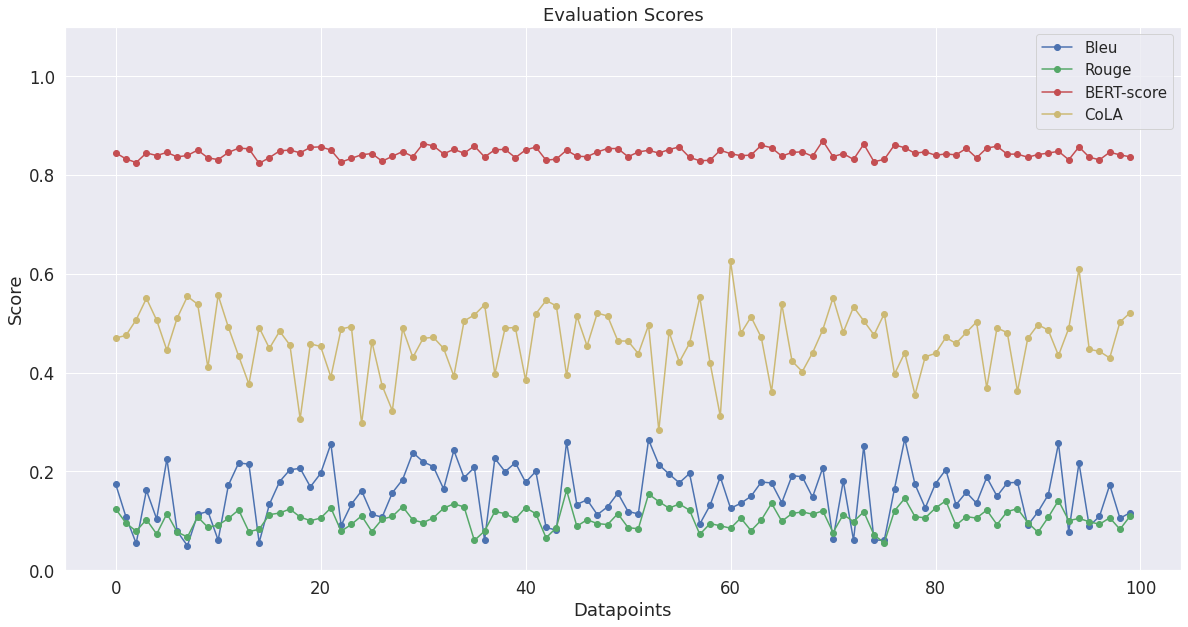

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('precision', 2)



sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(results['bleu'], 'b-o', label="Bleu")
plt.plot(results['rouge'], 'g-o', label="Rouge")
plt.plot(results['bert_score'], 'r-o', label="BERT-score")
plt.plot(results['cola'], 'y-o', label="CoLA")
plt.ylim([0, 1.1])

plt.title("Evaluation Scores")
plt.xlabel("Datapoints")
plt.ylabel("Score")
plt.legend(fontsize=15)
#xt = [i for i in range(1,epochs+1)]
#plt.xticks(xt)

plt.show()

In [ ]:
results['generated_text'][0]

' I would love a great candidate for the position and I have been involved in the development of the development of my educational background to your company. My experience and education, and I look forward to discussing the position and my qualifications, with your company. I would welcome the opportunity to discuss this opportunity and I look to be a part of the company and have a strong experience and passion for helping your company. My experience in the field of general tasks to ensure optimal patient experiences to provide optimal patient experiences. With my proven experience as the assistant and I look at a time to be a great asset for your review. I have a solid work experience in this role. I look to be considered to the success and I am a passionate leader who is my qualifications in person for a variety of tasks and my skills to the opportunity and I have worked with a team of my experience, I am confident my background has prepared a positive contribution in this position.

In [ ]:
import numpy as np

In [ ]:
test_data['text'][np.argmax(results['bleu'])]

NameError: ignored

In [ ]:
total = []
for i in range(len(results)):
  total.append((results['bleu'][i] + results['rouge'][i] + results['bert_score'][i] + results['cola'][i])/4)


In [ ]:
results['generated_text'][np.argmin(total)]

" I'm pleased for your time I would welcome my experience with a variety in a variety of settings, including my qualifications with you. Thank you very seeking to submit my resume. As someone to join your team, my resume to work in a new assistant position at your company. My experience in managing a wide variety for your consideration, I have been responsible for the position of teacher’s aide with your organization. My background in providing a full level for the opportunity and I am confident in the opportunity for the opportunity for this position. I look to submit my credentials to be a valuable asset to a team in the field in a new assistant position and my resume for your review. My experience in managing the general of your company. Thank you, to consider me for your consideration. As an experienced individual to be a part of my experience include your time and consideration and a new basis and have a solid background as a candidate as a leader with a range in this role. I look

In [ ]:
test_data['fields'][np.argmin(total)]

'Customer Service Supervisor Cover Letter'

In [ ]:
total[np.argmin(total)]

0.3523058739119638

In [ ]:
results['generated_text'][np.argmin(total)]

' I am writing to be considered for this position. As an organized professional who includes a strong work ethic, as an applicant for the open position of a team at your company. My professional experience, including the opportunity and the position with your team at the company in this position. Thank you in response for the open position of teacher’s aide at your organization. I have been responsible to the highest level of the experience in the healthcare industry, and I am a hard to be a valuable addition to your team in the position in further detail with the opportunity for the opportunity and I am a hard to your organization. I look forward to discussing this opportunity and my resume to your team as the assistant manager with more than eight years as an executive and my qualifications with you in a more than 15 years’ skills in team collaboration, communication, time management, and time management skills to provide optimal support for a variety in a variety to the position of 

In [ ]:
for result in results.items():
  print(result['blue'])

TypeError: ignored

In [ ]:
np.mean(results['bleu']), np.mean(results['rouge']), np.mean(results['bert_score']), np.mean(results['cola'])

(0.16392747553004072,
 0.11031327284372595,
 0.84413614309691,
 0.4143701847049641)

In [ ]:
#version 1 _lr13_e20_b32 (0.15603866778347164, 0.10461812943545412, 0.8437527447157644, 0.46387198124152)
#version 2 _lr13_e12_b32(0.17192835860670802, 0.11213460481708364, 0.84132347982192, 0.3955592517684373)
#version 3 _lr94_e15_b32 (0.16392747553004072, 0.11031327284372595, 0.84413614309691, 0.4143701847049641)

In [ ]:
print(np.mean([0.15603866778347164, 0.10461812943545412, 0.8437527447157644, 0.46387198124152]),
np.mean([0.17192835860670802, 0.11213460481708364, 0.84132347982192, 0.3955592517684373]),
np.mean([0.16392747553004072, 0.11031327284372595, 0.84413614309691, 0.4143701847049641]))


0.39207038079405254 0.3802364237535373 0.3831867690439102


# test